# Model Code for: DIN Loading Module
##  Island Wide Nutrient Modeling and Quantification of Coastal Freshwater Discharge for Tutuila, American Samoa, Script 2 of 2

The DIN Loading Module script contains the computational steps used to develop a Tutuila-wide DIN loading model as documented in the report "Island Wide Nutrient Modeling and Quantification of Coastal Freshwater Discharge for Tutuila, American Samoa" as authored by Shuler Hydrologic LLC and delivered to the American Samoa Environmental Protection Agency. The purpose of posting this project online in an open-source setting is to increase its methodological transparency and make the study entirely reproducible or modifiable as the user’s discretion. 

# Disclaimer
This script is provided as open-source software on the condition that neither Shuler Hydrologic LLC nor the American Samoa EPA shall be held liable for any damages resulting from the authorized or unauthorized use of the information. No warranty, expressed or implied, is made by Shuler Hydrologic LLC or the American Samoa EPA as to the accuracy and functioning of the program and related program material nor shall the fact of distribution constitute any such warranty and no responsibility is assumed by Shuler Hydrologic LLC in connection therewith.

This information is preliminary or provisional and is subject to revision.  This software is provided "AS IS."

Note that sensitive information, or datasets that are not publically available, are not posted in raw forms. The model code is licensed under the GNU General Public License v3.0 which is an open-access license designed to explicitly affirm any user’s unlimited permission to run, copy, and use the unmodified code from this repository. Please note that some raw datasets used in this work are not owned by the authors and may be subject to other licenses or conditions.

#### Prepared by:  
      Shuler Hydrologic LLC, Honolulu, HI 96826      
      
#### Prepared for:  
    American Samoa Environmental Protection Agency, P.O. Box PPA, Pago Pago, AS 96799

# Implementation

### 1) Import modules and set relative paths

In [1]:
import numpy as np
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import statsmodels.api as sm
import scipy.optimize as opt

homedir = os.getcwd()

Output = os.path.join('..', "Output")
if not os.path.exists(Output):
    os.makedirs(Output)
                      
fig_path = os.path.join(Output, "Figures")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

np.set_printoptions(suppress=True)

### 2) Define loacal functions used in this script for error calculation

In [2]:
# multiplication error 
def mul_err(x, y, xE, yE):         # x and y are the things being multiplied xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = (x*y)*np.sqrt(  (xE/x)**2+(yE/y)**2  )
    return SE

# Division error 
def div_err(x, y, xE, yE):         # x and y are the things being divided xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = (x/y)*np.sqrt(  (xE/x)**2+(yE/y)**2  )
    return SE

# addition error 
def add_err(xE, yE):         # x and y are the things being added xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = np.sqrt( xE**2+yE**2 )
    return SE

# subtraction error 
def sub_err(xE, yE):         # x and y are the things being subtracted xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = np.sqrt( xE**2+yE**2 )
    return SE


def add_err3(xE, yE, zE): 
    SE = np.sqrt( xE**2 + yE**2 + zE**2 )
    return SE

### 3) Load and muggle stream sample water quality data
This cell will: 
- Load raw data from the base raw data file "Consolidated_All_data_MASTER.xlsx"
- Determine which samples were take during runoff conditions vs during baseflow conditions based on the stream stage data
- summarize each sample site into a single row datadrame with average values for all samples, and can split up by RO or BF stage

In [3]:
# load up the excel data sheet
datapath = os.path.join("..", 'Raw_data', 'Tabular', "Consolidated_All_data_MASTER.xlsx")
data_xls = pd.read_excel(datapath, sheet_name='Consolidated_stream_data')#  index_col=0)  # read  xlsx to memory
data_xls = data_xls.dropna(subset=['Lat'])

# this block calculates the threshold value to define runoff vs baseflow conditions based on a multiplier of the mean recorded gauge height, change value below to mess with the threshold
ave_height_multiplyer_value = 1    # Currently 1.11 is the value that produces an average BF days to total flow days of 70% which is between Q60 and Q80 cite batsoni and Oki. (Actually using just mean for simplicity

av_hts = []; Vst = []
for i in data_xls['Village_stream'].unique():
    station_to_review = i
    review_frame = data_xls[data_xls['Village_stream'] == station_to_review]
    ave_ht =  review_frame['Guage_height_in'].mean()*ave_height_multiplyer_value   # hmm this uses the mean value to threshold RO from BF stream heights
    #ave_ht = np.percentile(review_frame['Guage_height_in'], 32)                    # and this uses a percentile value. I think using mean value straight for now. 
    av_hts.append(ave_ht); Vst.append(i)   
heighte_frame = pd.DataFrame({'Village_stream':Vst, 'Ave_gauge_height':av_hts})   # this is a dataframe of the stream names and the unique threshold heights 

def calculate_flo_type(row):                # this is a function to calculate BF or RO for each sample, based on the streams individual threshold height
    extracto = row['Village_stream']
    needval = heighte_frame[heighte_frame['Village_stream'] == extracto]
    ave_height_val = needval['Ave_gauge_height'].values[0]
    
    if row['Guage_height_in'] > ave_height_val:
        row['Flow_type'] = "RO"
    else:
        row['Flow_type'] = "BF"
        
    return row['Flow_type']

data_xls['Flow_type'] = data_xls.apply(calculate_flo_type, axis=1)


# this block creates a summary dataframe of each site
nam = []; count = []; avedin = []; avedin_ERR = []; aveSAL = []; avedin_BF =[]; avedin_BF_ERR =[]; avedin_RO =[]; avedin_RO_ERR =[]; cntBF = []; cntRO = []

for i in data_xls['Village_stream'].unique():
    tframe = data_xls[data_xls['Village_stream']==i]
    
    nam.append(i)
    count.append(len(tframe))
    avedin.append((tframe['DIN_uM']/71.39).mean())   # /71.39 is to convert uM of N to mg/L of N
    avedin_ERR.append((tframe['DIN_uM']/71.39).std())
    aveSAL.append(tframe['Salinity'].mean())
    

    cntBF.append(len(tframe[tframe['Flow_type'] == "BF"]))
    cntRO.append(len(tframe[tframe['Flow_type'] == "RO"]))
    
    avedin_BF.append((tframe[tframe['Flow_type'] == "BF"]['DIN_uM']/71.39).mean())
    avedin_BF_ERR.append((tframe[tframe['Flow_type'] == "BF"]['DIN_uM']/71.39).std())
    avedin_RO.append((tframe[tframe['Flow_type'] == "RO"]['DIN_uM']/71.39).mean())
    avedin_RO_ERR.append((tframe[tframe['Flow_type'] == "RO"]['DIN_uM']/71.39).std())
    
Stream_sample_summary_frame = pd.DataFrame({"Village_st":nam, "Samp_count":count, "Ave_DIN_uM":avedin, "Ave_DIN_uM_ERR":avedin_ERR, "Ave_Sal":aveSAL,
                              "aveDIN_BF":avedin_BF,"aveDIN_BF_ERR":avedin_BF_ERR, "aveDIN_RO":avedin_RO, "aveDIN_RO_ERR":avedin_RO_ERR, "BFcnt":cntBF, "ROcnt":cntRO})

Stream_sample_summary_frame['BF_TF_ratio'] = Stream_sample_summary_frame['BFcnt']/Stream_sample_summary_frame['Samp_count']
#Stream_sample_summary_frame.to_csv("Stream_sample_summary_frame.csv")

### 4) Load and muggle Coastal Spring water quality data

Note that coastal spring samples were unmixed to fresh end member saminities with the oceanic end member used in Shuler et al. 2017 and the method from Hunt and Rosa (2009):

Ocean unmixed DIN concentrations were caluculated using the following unmixing calculation taken from Hunt and Rosa (2009): 

Sample_DIN + (Samp_DIN-Ocean_DIN)*(Sample_Salinity-Fresh_salinity)/(Ocean_Salinity -Sample_Salinity)

     Where
     Ocean_Salinity = 35.27
     Fresh Salinity = 0.1
     Ocean_DIN = 0.370 uM
     
(this calculation was performed previously in an excel sheet)

In [4]:
# load up the excel data sheet
data_xls2 = pd.read_excel(datapath, sheet_name='Consolidated_CSP_data')#  index_col=0)  # read  xlsx to memory
data_xls2 = data_xls2.dropna(subset=['Lat'])       # remove any rows with no lat meaning no data

# this block creates a summary dataframe of each site
nam = []; count = []; avedin = []; std = []; aveSAL = [];

for i in data_xls2['Uniqe_ID'].unique():
    tframe = data_xls2[data_xls2['Uniqe_ID']==i]
    
    nam.append(i)
    count.append(len(tframe))
    avedin.append((tframe['UNMIXED_DIN_uM']/71.39).mean())  # /71.39 is to convert uM of N to mg/L of N
    std.append((tframe['UNMIXED_DIN_uM']/71.39).std())
    aveSAL.append(tframe['Salinity'].mean())
    
CSP_sample_summary_frame = pd.DataFrame({"Uniqe_ID":nam, "Samp_count":count, "Ave_UnMix_CSP_DIN_mgpL":avedin, "Ave_UnMix_CSP_DIN_mgpL_ERR":std, "Ave_Sal":aveSAL})
#CSP_sample_summary_frame.to_csv("CSPs.csv")

### 5) Merge all data into giant dataframe
keyed out mainly by the Village_st code, 
but also my the Uniqe_ID code from the water budget model zones
includes stream sample data, land use sources (OSDS, Pigs_AG), and SWB2 components from the SWB2_model_R2R_ver2 script

In [5]:
# open up the land use factors shapefile and merge it on to the stream sample dataframe
gdf = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "AG_OSDS_PIGS_NATURAL_ACTIVE_WS.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
LUsource_frame = Stream_sample_summary_frame.merge(gdf, on='Village_st', how='right')
del LUsource_frame['geometry']

# open up the pumprates shapefile and merge it on to the land use dataframe
prates = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "Pumprates.shp"))
del prates['geometry']
LUsource_pump_frame = LUsource_frame.merge(prates, on='Uniqe_ID', how='outer')

# add on the SWB2 WB results for each watershed (note: using inner to omit the sheds that were not sampled.)
wb_results = pd.read_csv(os.path.join('..', "Workspace",'SWB2_results', 'WB_by_shed_m3pd_Fixed.csv'), index_col=0)     # this file comes out of the SWB2_model_R2R_ver2 script
merge_frame2 = LUsource_pump_frame.merge(wb_results, on='Uniqe_ID', how='outer')

# add shoreline lengths in km
perims = geopandas.read_file(os.path.join("..", "Raw_data", "GIS",  "Sub_basin_perimeters.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
del perims['geometry']
merge_frame2p5 = merge_frame2.merge(perims, on='Uniqe_ID', how='outer')

# add on the coastal springs where available
CSP_to_merge = CSP_sample_summary_frame[['Uniqe_ID','Ave_UnMix_CSP_DIN_mgpL','Ave_UnMix_CSP_DIN_mgpL_ERR']]
merge_frame3 = merge_frame2p5.merge(CSP_to_merge, on='Uniqe_ID', how='outer')

# Remove the baseflow from Leone Volcanic areas and add it in as SGD since these areas have no baseflow
merge_frame3 = merge_frame3.reset_index(drop = True)

no_Bflow_bros = ['WS_64_Tafuna Plain', 'WS_65_Fagatele - Larsen', 'WS_98_Leone_Maloata']  # list of zones with no known baseflow

for i in no_Bflow_bros:   # for each of those areas...
    for q in range(0, len(merge_frame3.index)):    # check each row
        
        if merge_frame3.at[q, 'Uniqe_ID'] == i:
            print(i)
            flow_to_add = merge_frame3.at[q, 'baseflow']                                        # grab the BF
            merge_frame3.at[q, 'SGD_m3pd'] = (merge_frame3.at[q, 'SGD_m3pd'] + flow_to_add)     # add it to the SGD
            merge_frame3.at[q, 'baseflow'] = 0                                                  # remove the BF
            
            
# make an SGD column that takes account of pumping
merge_frame3['SGD_m3pd_w_pumping']  = merge_frame3['SGD_m3pd'] - merge_frame3['TotGWQm3pd'] 

WS_64_Tafuna Plain
WS_65_Fagatele - Larsen
WS_98_Leone_Maloata


### 6) create loading colums based on some assumptions:  
 - 1: BF load is composed of aveDIN_BF and baseflow
 - 2: RO load is composed of aveDIN_RO and runoff
 - 3: SGD load is composed of Ave_UnMix_CSP_DIN_uM and SGD

In [6]:
merge_frame3['BF_DIN_lOAD_kgNpd'] = (merge_frame3['aveDIN_BF']/1000) * merge_frame3['baseflow']    # converting from mgN/L and m3pd to KgN/m3
merge_frame3['RO_DIN_lOAD_kgNpd'] = (merge_frame3['aveDIN_RO']/1000) * merge_frame3['runoff'] 
merge_frame3['SGD_DIN_lOAD_kgNpd'] = (merge_frame3['Ave_UnMix_CSP_DIN_mgpL']/1000) * merge_frame3['SGD_m3pd_w_pumping'] 

merge_frame3['Total_DIN_lOAD_kgNpd'] = merge_frame3['SGD_DIN_lOAD_kgNpd'] + merge_frame3['RO_DIN_lOAD_kgNpd'] + merge_frame3['BF_DIN_lOAD_kgNpd']


# error columns
x = merge_frame3['aveDIN_BF']/1000; y = merge_frame3['baseflow']; xE = merge_frame3['aveDIN_BF_ERR']/1000; yE =  merge_frame3['baseflow_std']
merge_frame3['BF_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )

x = merge_frame3['aveDIN_RO']/1000; y = merge_frame3['runoff']; xE = merge_frame3['aveDIN_RO_ERR']/1000; yE =  (merge_frame3['runoff']*.10) # assign 10% error
merge_frame3['RO_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )

x = merge_frame3['Ave_UnMix_CSP_DIN_mgpL']/1000; y = merge_frame3['SGD_m3pd_w_pumping']; xE = merge_frame3['Ave_UnMix_CSP_DIN_mgpL_ERR']/1000; yE =  (merge_frame3['SGD_std']*.10) # assign 10% error
merge_frame3['SGD_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )


x = merge_frame3['BF_DIN_lOAD_kgNpd']; y = merge_frame3['RO_DIN_lOAD_kgNpd']; z = merge_frame3['SGD_DIN_lOAD_kgNpd']
xE = merge_frame3['BF_DIN_lOAD_kgNpd_ERR']; yE = merge_frame3['RO_DIN_lOAD_kgNpd_ERR']; zE = merge_frame3['SGD_DIN_lOAD_kgNpd_ERR']
merge_frame3['Total_DIN_lOAD_kgNpd_ERR'] = add_err3(xE, yE, zE)


### 7)  Loading parameter coefficient optomization

Seems to provide attenuation rates that match the Shuler et al. (2017) reasonably well. 

In [7]:
Optomo_frame3 = merge_frame3.copy()

def LoadModel(params):
   # this changes the coefficient(s)

    O_at, P_at, A_at = params 

    Optomo_frame3["OSDS_ShulerLoad"] = Optomo_frame3["OSDS_cnt"] * ((21/1000)*O_at)     # this is loading rate in g/d * (1-atteniuation coefficient)/1000 to make kg/d 
    Optomo_frame3["PIG_ShulerLoad"] = Optomo_frame3["Pig_cnt"] * ((38.1/1000)*P_at)
    Optomo_frame3["AG_ShulerLoad"] = Optomo_frame3["ag_area_m2"]/8281*((6.38/1000)*A_at)  # this is per 8281 m2 of area which was the cell size in shuler 2017 model 
    Optomo_frame3["NAT_ShulerLoad"] = Optomo_frame3["NatArea"]/8281*((3)/1000)  # this is arbitrary for now
    Optomo_frame3["Total_ShulerLoad"] = Optomo_frame3["OSDS_ShulerLoad"]+ Optomo_frame3["PIG_ShulerLoad"]+ Optomo_frame3["AG_ShulerLoad"]+ Optomo_frame3["NAT_ShulerLoad"]

    y_obs = Optomo_frame3["Total_ShulerLoad"]
    x = Optomo_frame3["Total_DIN_lOAD_kgNpd"]
    
    return x, y_obs

def optomizo(params):
    
    x = LoadModel(params)[0]
    y_obs = LoadModel(params)[1]
    
    # this is the error part of the function
    desired_slope = 1
    desired_int = 1
    y_mod = desired_slope * x + desired_int
    err_series =  y_mod - y_obs  # ( y = mX+b  minus observed Ys) 
    MAE = abs(err_series).mean()    
    
    #print(MAE)
    return MAE

results = opt.minimize(optomizo, x0= [1, 1, 1], method="Nelder-Mead",tol = 0.01)
results

 final_simplex: (array([[1.76953774, 0.26635588, 0.75384968],
       [1.77161006, 0.2656835 , 0.74657124],
       [1.77209114, 0.26553458, 0.76077839],
       [1.77012211, 0.26570428, 0.75443823]]), array([1.07814221, 1.07831846, 1.07834891, 1.07859139]))
           fun: 1.0781422054577021
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 51
        status: 0
       success: True
             x: array([1.76953774, 0.26635588, 0.75384968])

### 8) Interpret and summarize results
#### 8.1) # Do some land use loading calculations to add to the dataframe:

In [8]:
ag_load_kg_per_day_per_km2 = (6.36/1000)/8281*1000000    ;   print('ag_load_kg_per_day_per_km2   ' + str(ag_load_kg_per_day_per_km2))
natural_load_kg_per_day_per_km2 = (3/1000)/8281*1000000  ;   print('natural_load_kg_per_day_per_km2   ' + str(natural_load_kg_per_day_per_km2))

# quick final loading rates here
OSDS_Act_load_kgpd = (21/1000)*results.x[0]  ;   print('OSDS_Act_load_kgpd   ' + str(OSDS_Act_load_kgpd))
pig_Act_load_kgpd = (38/1000)*results.x[1]    ;   print('pig_Act_load_kgpd   ' + str(pig_Act_load_kgpd))
ag_Act_load_kgpd = (ag_load_kg_per_day_per_km2)*results.x[2]    ;   print('ag_Act_load_kgpd   ' + str(ag_Act_load_kgpd))

ag_load_kg_per_day_per_km2   0.7680231856056032
natural_load_kg_per_day_per_km2   0.36227508754981286
OSDS_Act_load_kgpd   0.037160292475972447
pig_Act_load_kgpd   0.010121523501457706
ag_Act_load_kgpd   0.5789740295707249


#### 8.2) Plot comparison of idealized  slope and intercept vs. least squares model 

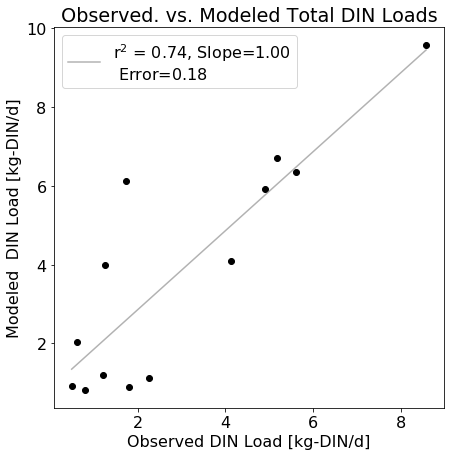

In [9]:
plt.rcParams.update({'font.size': 16})

x, y = LoadModel([ results['x'][0], results['x'][1], results['x'][2] ])

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x, y, label ="", color='k')
ax.set_xlabel("Observed DIN Load [kg-DIN/d]", color='k') 
ax.set_ylabel("Modeled  DIN Load [kg-DIN/d]", color='k')

#    # plop on a regression line
mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
r2 = r_value**2
rX = np.linspace(min(x[mask]), max(x[mask]), 50)
rY = slope*rX + intercept
ax.plot(rX,rY, color='grey', linestyle='-', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%1 +"\n Error="+"$%.2f$"%std_err) )   
ax.legend(loc=2) 
plt.title("Observed. vs. Modeled Total DIN Loads")

plt.savefig(os.path.join(fig_path, "Final_plot1.png"), dpi = 300)

#### 8.3) Scatter plot matrices
to see how each WQ variable responds to each source variable.

plotted in a couple of ways cuz plots are fun

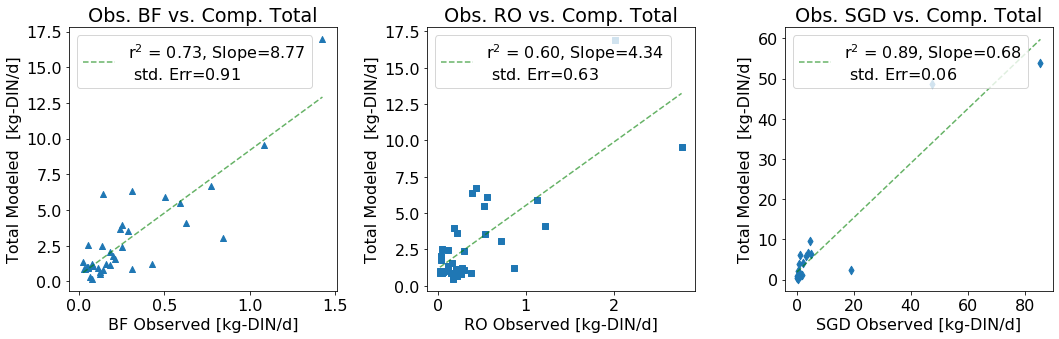

In [10]:
load_list = ['BF_DIN_lOAD_kgNpd', 'RO_DIN_lOAD_kgNpd', 'SGD_DIN_lOAD_kgNpd']
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad', 'Total_ShulerLoad']

plt.rcParams.update({'font.size': 16})

mark = ['^', "s", 'd']

fig, ax = plt.subplots(1,3, figsize=(15, 5))
for idx,  L in enumerate(load_list):

    x = Optomo_frame3[L]
    y = Optomo_frame3['Total_ShulerLoad']
    
    ax[idx].scatter(x, y, label ='', marker=mark[idx])
    ax[idx].set_xlabel(x.name.split("_")[0]+" Observed [kg-DIN/d]", color='k') 
    ax[idx].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')
    
    #    # plop on a regression line
    mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2
    rX = np.linspace(min(x), max(x), 50)
    rY = slope*rX + intercept
    ax[idx].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
    ax[idx].legend(loc=2) 
    ax[idx].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))

    plt.tight_layout()
plt.savefig(os.path.join(fig_path, "flo_type_matrix.png"), dpi = 300)     

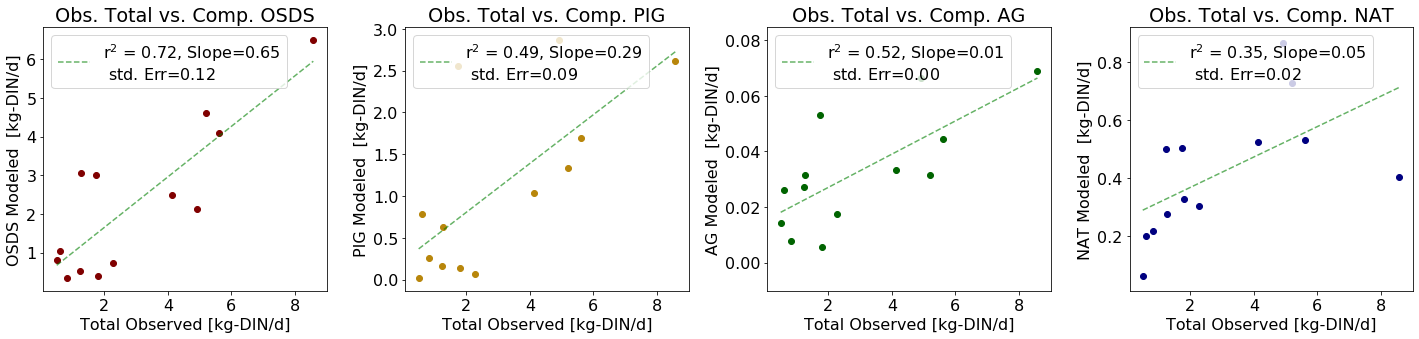

In [11]:
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad']

fig, ax = plt.subplots(1,4, figsize=(20, 5))

colo = np.array(["maroon", "darkgoldenrod", "darkgreen", "navy"])
           
for idx,  L in enumerate(LU_list):

    y = Optomo_frame3[L]
    x = Optomo_frame3['Total_DIN_lOAD_kgNpd']
    
    ax[idx].scatter(x, y, label ='', c = colo[idx])
    ax[idx].set_xlabel(x.name.split("_")[0]+" Observed [kg-DIN/d]", color='k') 
    ax[idx].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')
    
    #    # plop on a regression line
    mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2
    rX = np.linspace(min(x), max(x), 50)
    rY = slope*rX + intercept
    ax[idx].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
    ax[idx].legend(loc=2) 
    ax[idx].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))

    plt.tight_layout()
plt.savefig(os.path.join(fig_path, "Source_type_matrix.png"), dpi = 300)     

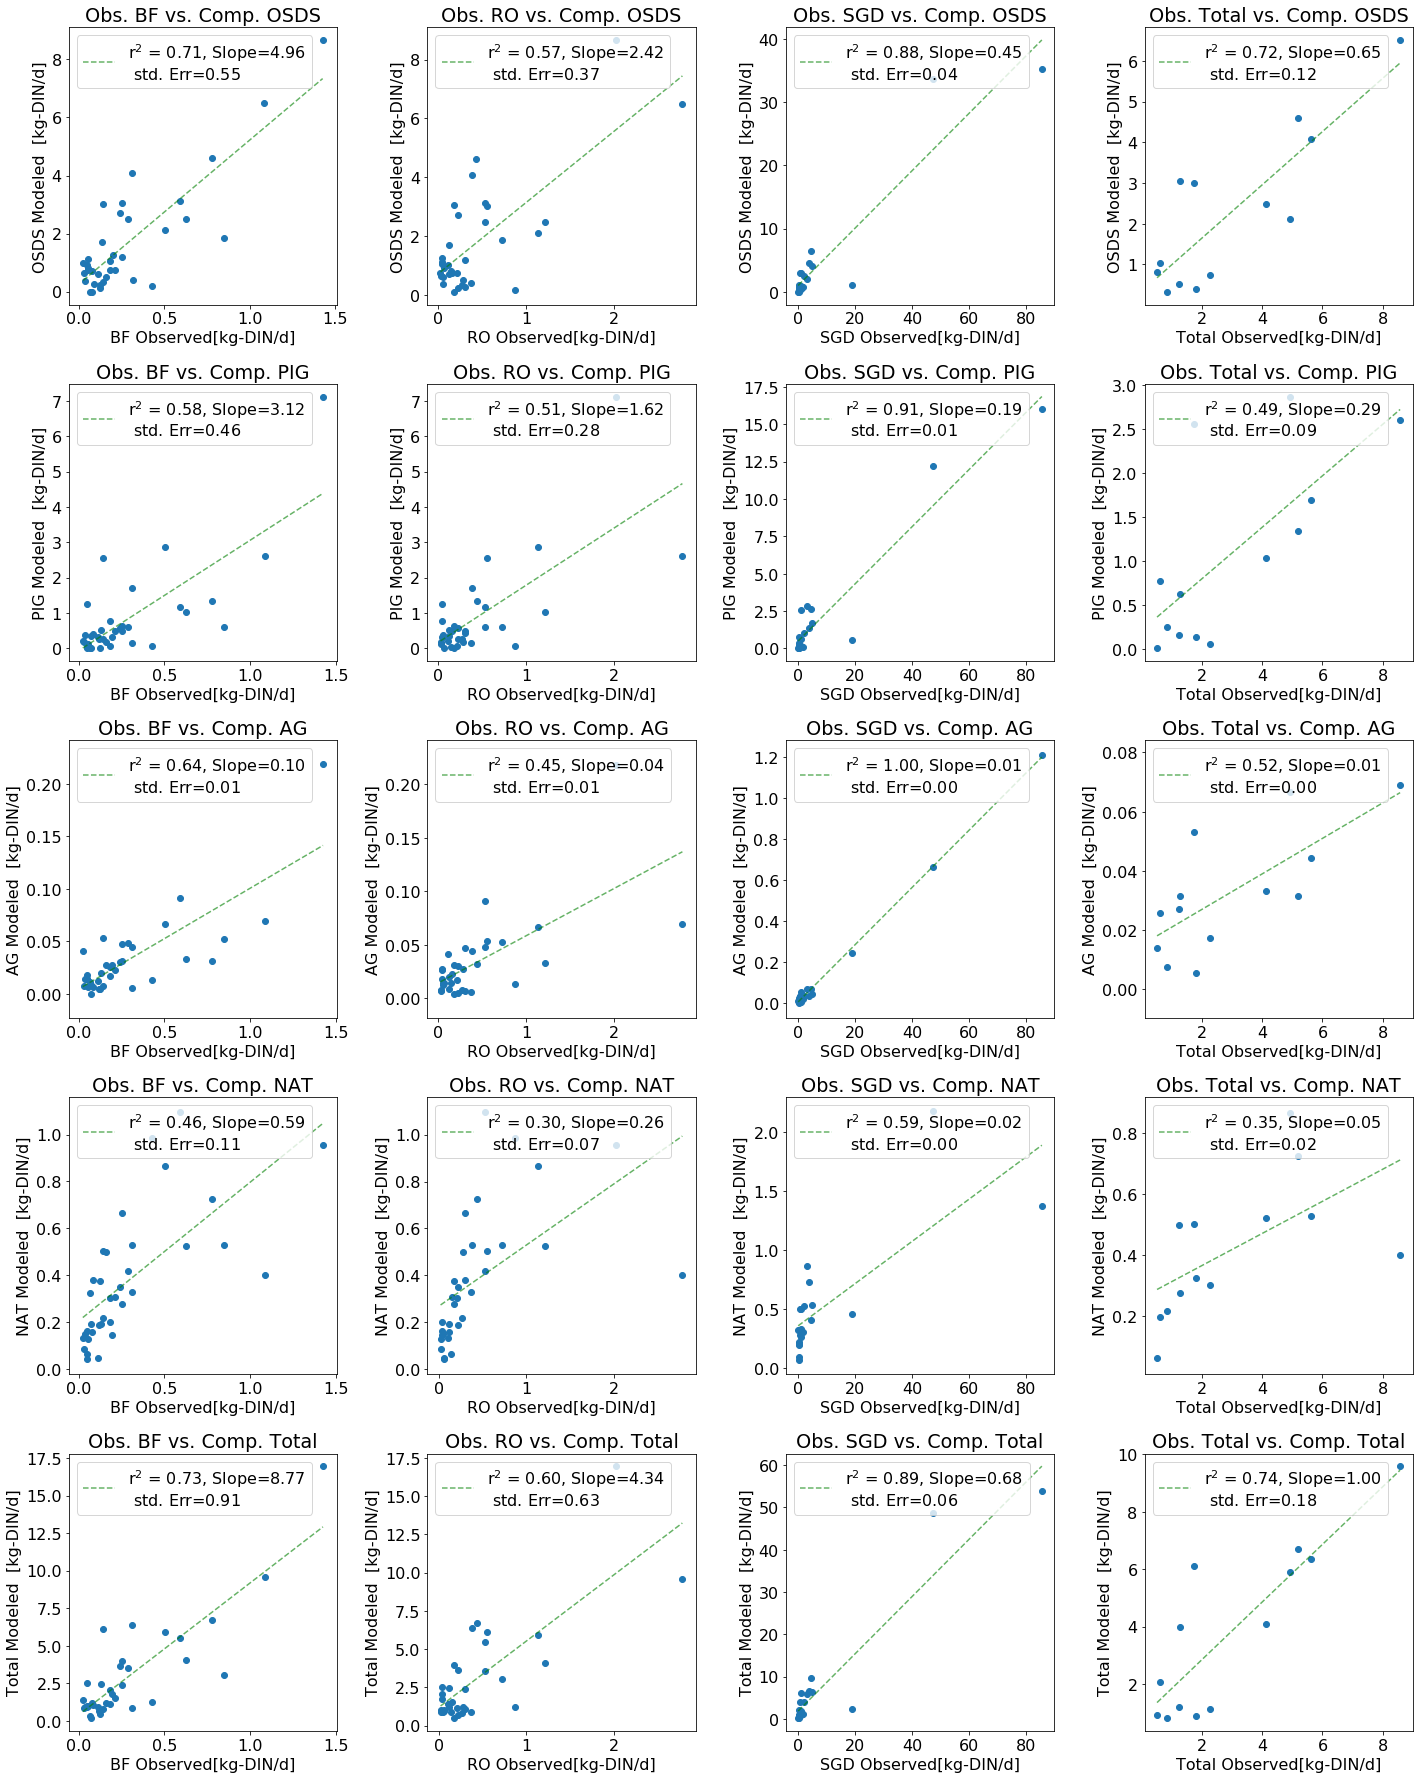

In [12]:
load_list = ['BF_DIN_lOAD_kgNpd', 'RO_DIN_lOAD_kgNpd', 'SGD_DIN_lOAD_kgNpd', 'Total_DIN_lOAD_kgNpd']
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad', 'Total_ShulerLoad']


plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(5,4, figsize=(20, 25))
nrow  = -1 # plot iterators

for L in load_list:
    ncol = -1   # plot iterators
    nrow = nrow+1  # plot iterators
    x = Optomo_frame3[L]
    
    for U in LU_list:
        ncol = ncol+1  # plot iterators
    
        y = Optomo_frame3[U]

        ax[ncol,nrow].scatter(x, y, label ='')
        ax[ncol,nrow].set_xlabel(x.name.split("_")[0]+" Observed[kg-DIN/d]", color='k') 
        ax[ncol,nrow].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')

    #    # plop on a regression line
        mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
        r2 = r_value**2
        rX = np.linspace(min(x), max(x), 50)
        rY = slope*rX + intercept
        ax[ncol,nrow].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
        ax[ncol,nrow].legend(loc=2) 
        ax[ncol,nrow].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))
        
        plt.tight_layout()

plt.savefig(os.path.join(fig_path, "Scat_matrix.png"), dpi = 300)     

#### 8.4) Area or length scaled DIN loads 

In [13]:
# per area nutrient loading 
Optomo_frame3['Load_per_km2_kgDINpdpkm2'] = Optomo_frame3['Total_ShulerLoad'] / (Optomo_frame3['area_m2']/1000000)

# Per lengh of coastline loading make a column for the total shuler load per coastline length for a figure result
Optomo_frame3['DINpKm_len'] = Optomo_frame3['Total_ShulerLoad'] / Optomo_frame3['s_len_km']

#### 8.5) Prioritization ranking using absolute and scaled loads 

In [14]:
Prioritization_frame = Optomo_frame3.copy()     # dont mess with original dataframe

# find averages of each metric 
DINpKm_len_mean = Prioritization_frame['DINpKm_len'].mean()
Total_ShulerLoad_mean = Prioritization_frame['Total_ShulerLoad'].mean()
Load_per_km2_kgDINpdpkm2_mean = Prioritization_frame['Load_per_km2_kgDINpdpkm2'].mean()

# find anomolies for later ranking
Prioritization_frame['DINpKm_len_anomoly'] = Prioritization_frame['DINpKm_len'] - DINpKm_len_mean
Prioritization_frame['Total_ShulerLoad_anomoly'] = Prioritization_frame['Total_ShulerLoad'] - Total_ShulerLoad_mean
Prioritization_frame['Load_per_km2_kgDINpdpkm2_anomoly'] = Prioritization_frame['Load_per_km2_kgDINpdpkm2'] - Load_per_km2_kgDINpdpkm2_mean

# rank the anomoloies, 1 to 93
Prioritization_frame['DINpKm_len_RANK'] = Prioritization_frame['DINpKm_len_anomoly'].rank(ascending=True)
Prioritization_frame['Total_ShulerLoad_RANK'] = Prioritization_frame['Total_ShulerLoad_anomoly'].rank(ascending=True)
Prioritization_frame['Load_per_km2_kgDINpdpkm2_RANK'] = Prioritization_frame['Load_per_km2_kgDINpdpkm2_anomoly'].rank(ascending=True)

# add each of the ranks (this means equal weight is placed on each one) 
Prioritization_frame['Rank_sum'] = Prioritization_frame['DINpKm_len_RANK'] + Prioritization_frame['Total_ShulerLoad_RANK'] + Prioritization_frame['Load_per_km2_kgDINpdpkm2_RANK']

# rank those again to get 1-93 rank, note the 1 is highest impact here
Prioritization_frame['Ranked_RANK'] = Prioritization_frame['Rank_sum'].rank(ascending=False)

# sort it so 1 is on top
Prioritization_frame = Prioritization_frame.sort_values("Ranked_RANK", ascending=False)

### 9) D15N Predicted Isotope model

In [15]:
f_OSDS = Optomo_frame3['OSDS_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_Pig = Optomo_frame3['PIG_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_AG = Optomo_frame3['AG_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_Nat= Optomo_frame3['NAT_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']

D_OSDS = 9
D_Pig = 14
D_AG = 0
D_Nat = 4

Optomo_frame3['predicted_D15N_permil'] = (f_OSDS*D_OSDS + f_Pig*D_Pig + f_AG*D_AG + f_Nat*D_Nat)
overall_ave_d15N = Optomo_frame3['predicted_D15N_permil'].mean()

Optomo_frame3['predicted_D15N_relative']= (Optomo_frame3['predicted_D15N_permil'] - overall_ave_d15N)

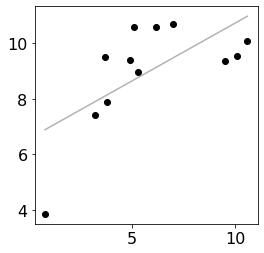

MAE is 2.8438668817094785, and paramaters are OSDS = 9.0, pig = 14.0, Ag = 0.0, Nat = 4.0


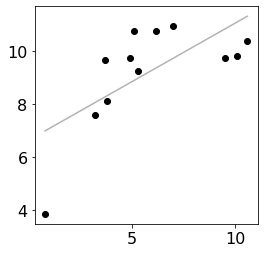

MAE is 2.907332841465944, and paramaters are OSDS = 9.450000000000001, pig = 14.0, Ag = 0.0, Nat = 4.0


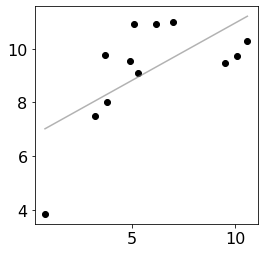

MAE is 2.9481612022622046, and paramaters are OSDS = 9.0, pig = 14.700000000000001, Ag = 0.0, Nat = 4.0


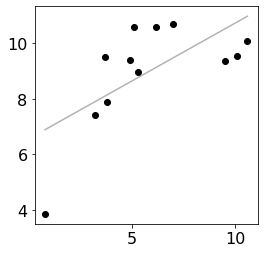

MAE is 2.843869041874935, and paramaters are OSDS = 9.0, pig = 14.0, Ag = 0.00025, Nat = 4.0


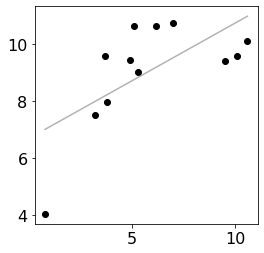

MAE is 2.8841332788190948, and paramaters are OSDS = 9.0, pig = 14.0, Ag = 0.0, Nat = 4.2


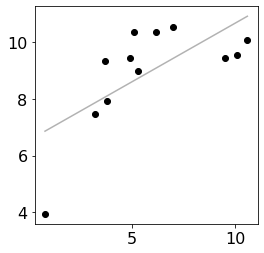

MAE is 2.791439819672521, and paramaters are OSDS = 9.225000000000001, pig = 13.299999999999999, Ag = 0.000125, Nat = 4.1


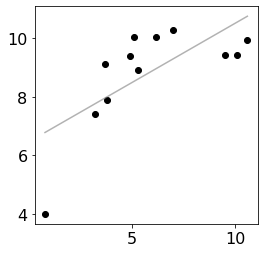

MAE is 2.7130791283776787, and paramaters are OSDS = 9.337500000000002, pig = 12.599999999999998, Ag = 0.0001875, Nat = 4.149999999999999


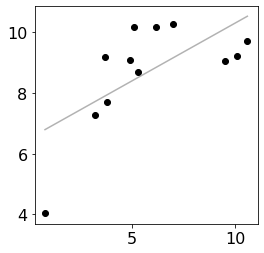

MAE is 2.73514132392465, and paramaters are OSDS = 8.718750000000002, pig = 13.299999999999997, Ag = 0.00021875, Nat = 4.174999999999999


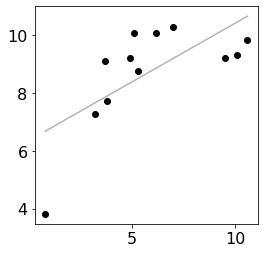

MAE is 2.6838449091242764, and paramaters are OSDS = 9.028125000000003, pig = 12.949999999999996, Ag = 0.000328125, Nat = 3.9624999999999977


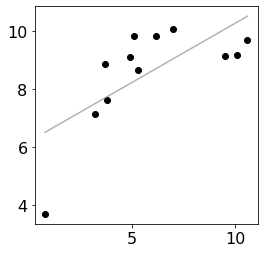

MAE is 2.583700724276866, and paramaters are OSDS = 9.042187500000004, pig = 12.424999999999997, Ag = 0.0004921875, Nat = 3.8437499999999964


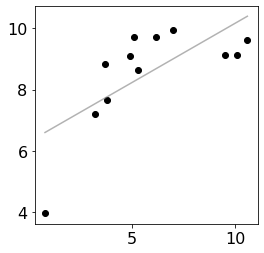

MAE is 2.594024987269403, and paramaters are OSDS = 9.049218750000005, pig = 12.162499999999994, Ag = 0.00019921874999999996, Nat = 4.084374999999998


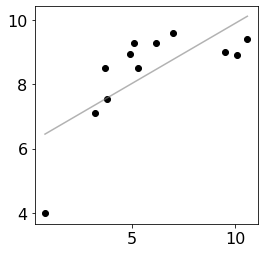

MAE is 2.46910620021482, and paramaters are OSDS = 9.073828125000006, pig = 11.243749999999991, Ag = 0.0005488281249999999, Nat = 4.126562499999995


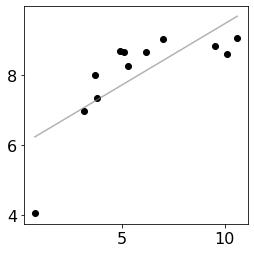

MAE is 2.2817258594674894, and paramaters are OSDS = 9.110742187500009, pig = 9.865624999999987, Ag = 0.0008232421875, Nat = 4.1898437499999925


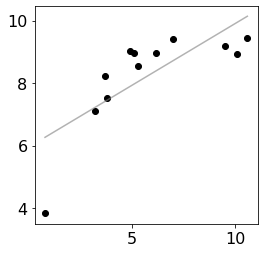

MAE is 2.3511240257710706, and paramaters are OSDS = 9.551074218750008, pig = 10.226562499999993, Ag = 0.00063232421875, Nat = 3.9589843749999947


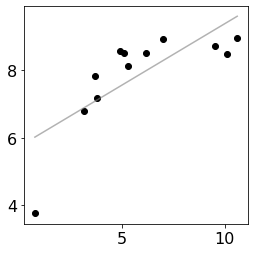

MAE is 2.1922086700147356, and paramaters are OSDS = 9.039111328125014, pig = 9.739843749999988, Ag = 0.0008859863281250001, Nat = 3.888476562499992


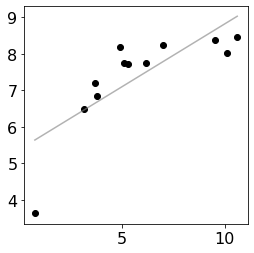

MAE is 1.931773440833264, and paramaters are OSDS = 8.88991699218752, pig = 8.309765624999983, Ag = 0.0012352294921875, Nat = 3.757714843749989


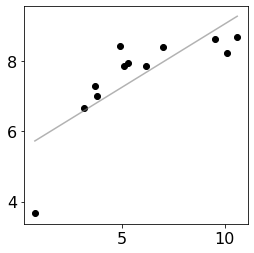

MAE is 1.9801370379049423, and paramaters are OSDS = 9.247741699218764, pig = 8.250976562499986, Ag = 0.00139227294921875, Nat = 3.7907714843749885


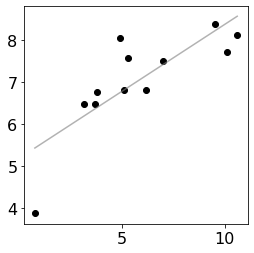

MAE is 1.84212954533474, and paramaters are OSDS = 9.357550048828145, pig = 5.901464843749977, Ag = 0.0015493469238281247, Nat = 4.004907226562486


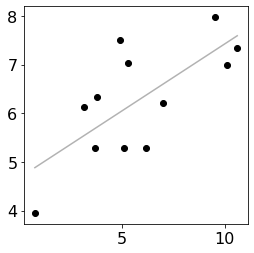

MAE is 1.9962430140328795, and paramaters are OSDS = 9.515231323242215, pig = 2.6396972656249673, Ag = 0.002077926635742187, Nat = 4.085485839843731


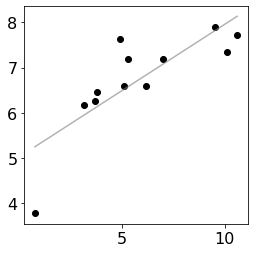

MAE is 1.8289305869193322, and paramaters are OSDS = 8.751901245117212, pig = 5.937353515624974, Ag = 0.0018677215576171874, Nat = 3.9126342773437335


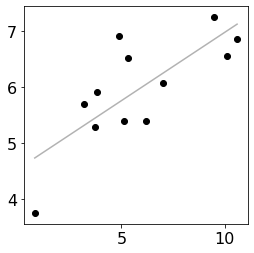

MAE is 1.9471851310633241, and paramaters are OSDS = 8.352314758300814, pig = 3.792749023437466, Ag = 0.0024854202270507813, Nat = 3.8894592285156033


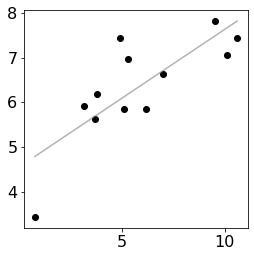

MAE is 1.8111403747200896, and paramaters are OSDS = 9.012812805175813, pig = 4.334155273437473, Ag = 0.002199043273925781, Nat = 3.5431701660156065


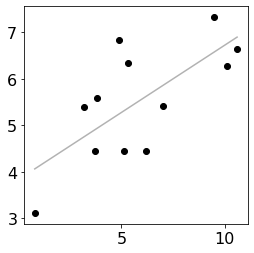

MAE is 2.038059914210485, and paramaters are OSDS = 8.963848114013715, pig = 1.5684204101562145, Ag = 0.0028869438171386713, Nat = 3.2198333740234126


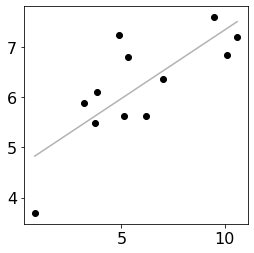

MAE is 1.8949707246485354, and paramaters are OSDS = 8.758348846435581, pig = 3.9903930664062166, Ag = 0.002033397674560547, Nat = 3.818441772460919


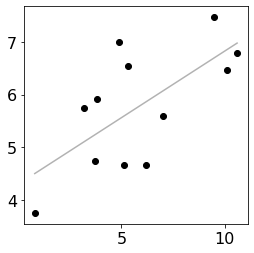

MAE is 2.0680436955267996, and paramaters are OSDS = 9.050389480590855, pig = 1.7719177246093363, Ag = 0.0025895252227783206, Nat = 3.8818618774413842


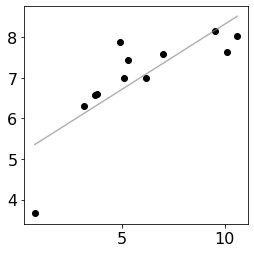

MAE is 1.8062934109147595, and paramaters are OSDS = 8.930035114288353, pig = 6.675303649902322, Ag = 0.0015738034248352051, Nat = 3.788751602172838


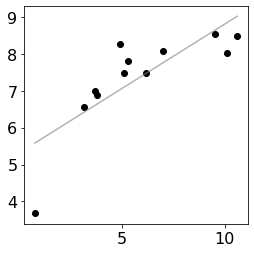

MAE is 1.8643310992364377, and paramaters are OSDS = 9.267800760269179, pig = 7.433745574951157, Ag = 0.001561559915542602, Nat = 3.8062898635864135


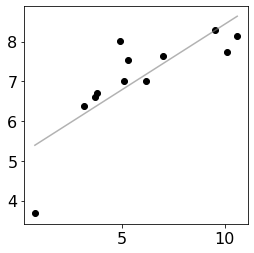

MAE is 1.8091036084834675, and paramaters are OSDS = 9.140437781810778, pig = 6.572907447814922, Ag = 0.001679519355297088, Nat = 3.80932784080504


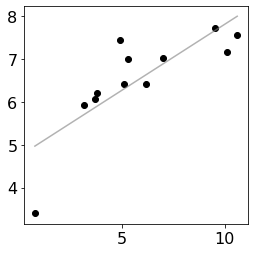

MAE is 1.7643662233322814, and paramaters are OSDS = 8.560043424367933, pig = 5.858395099639868, Ag = 0.0021106968820095062, Nat = 3.5220347166061226


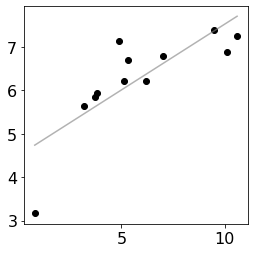

MAE is 1.7254845623310515, and paramaters are OSDS = 8.161290112137827, pig = 5.836860227584815, Ag = 0.002391371861100197, Nat = 3.2805984616279407


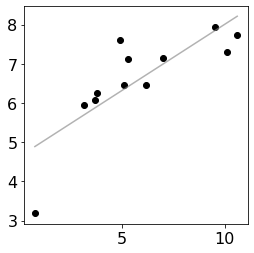

MAE is 1.7258421694535484, and paramaters are OSDS = 8.87038666158917, pig = 5.7722597837447935, Ag = 0.0020541473999619478, Nat = 3.2982897579669785


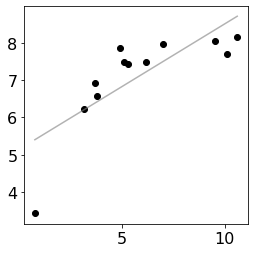

MAE is 1.813896790707733, and paramaters are OSDS = 8.538262029737254, pig = 8.094510281085954, Ag = 0.001650377746671438, Nat = 3.5453136652707915


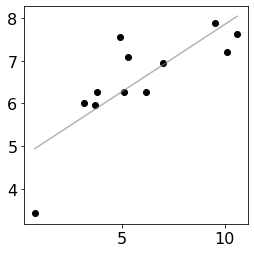

MAE is 1.7676724344060946, and paramaters are OSDS = 8.894175111316173, pig = 5.274244025349593, Ag = 0.002061876892112195, Nat = 3.5437060408294028


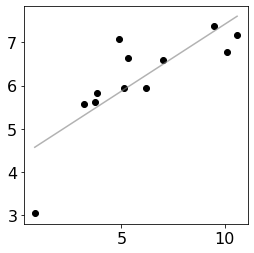

MAE is 1.7286633281133448, and paramaters are OSDS = 8.287505717854984, pig = 5.206426395475839, Ag = 0.002361080433707685, Nat = 3.1463450904935395


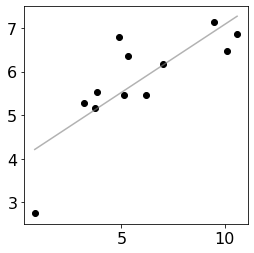

MAE is 1.761556396633811, and paramaters are OSDS = 8.176643687160725, pig = 4.369591566175197, Ag = 0.002860434868605807, Nat = 2.845718073286093


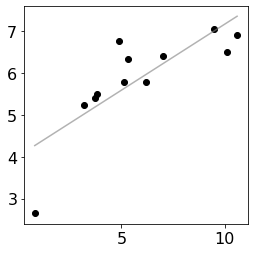

MAE is 1.6891279853319212, and paramaters are OSDS = 7.853737978055182, pig = 5.3183249611407275, Ag = 0.0027716403895756228, Nat = 2.7417696508578735


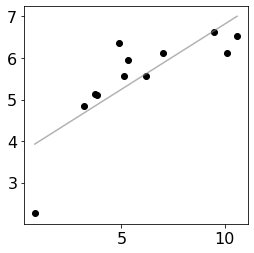

MAE is 1.7229286954505483, and paramaters are OSDS = 7.333519411424689, pig = 5.340365429036295, Ag = 0.0031265221383073366, Nat = 2.3408014558721097


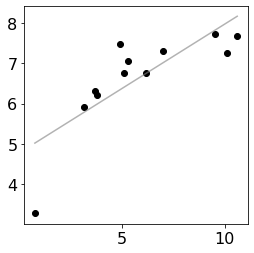

MAE is 1.741082707525934, and paramaters are OSDS = 8.409816547657856, pig = 6.697344117797892, Ag = 0.0019286851735669194, Nat = 3.3877834071870736


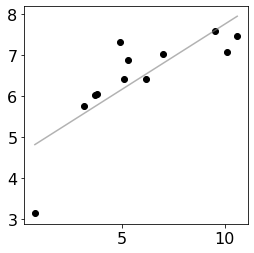

MAE is 1.7195564086982555, and paramaters are OSDS = 8.351523332533574, pig = 6.115405979892219, Ag = 0.0021616225973266415, Nat = 3.2522670737118284


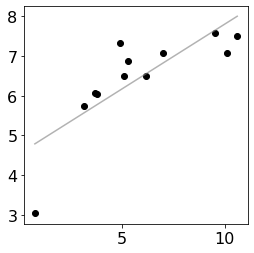

MAE is 1.7005244039863905, and paramaters are OSDS = 8.330963324302893, pig = 6.314999080705439, Ag = 0.002328310690274519, Nat = 3.140117381588771


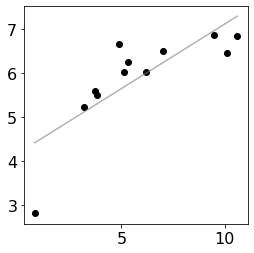

MAE is 1.6852381295660575, and paramaters are OSDS = 7.478370711925566, pig = 6.0205353409168065, Ag = 0.002772325369176543, Nat = 2.909086525926228


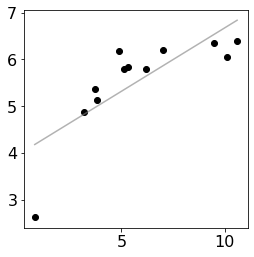

MAE is 1.7635639644925931, and paramaters are OSDS = 6.782362737093763, pig = 6.144673119502812, Ag = 0.0031314143537838407, Nat = 2.7144849099058526


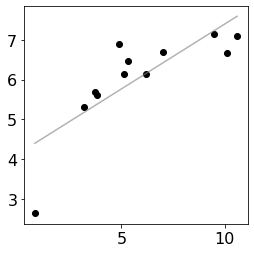

MAE is 1.6359643737597542, and paramaters are OSDS = 7.846007561270781, pig = 6.047772453742782, Ag = 0.002625577662076466, Nat = 2.7410218544144094


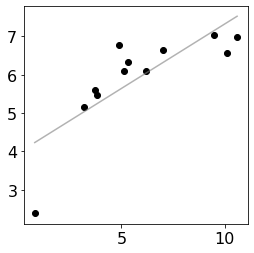

MAE is 1.5922274540190557, and paramaters are OSDS = 7.688366285837258, pig = 6.153228566821767, Ag = 0.0027426805625646008, Nat = 2.471233550807643


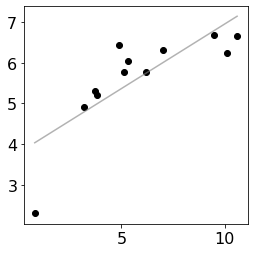

MAE is 1.6770636953655005, and paramaters are OSDS = 7.324195817526874, pig = 5.7881379949001515, Ag = 0.003145855908469001, Nat = 2.3788364808784292


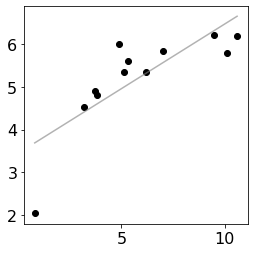

MAE is 1.7796287774005108, and paramaters are OSDS = 6.841372072369547, pig = 5.325114351184286, Ag = 0.0033879404246183647, Nat = 2.1103457226463163


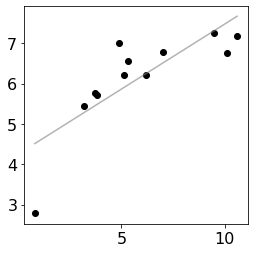

MAE is 1.6592294272121386, and paramaters are OSDS = 7.958565511319556, pig = 6.067527898325151, Ag = 0.0025932181238604805, Nat = 2.882674466853157


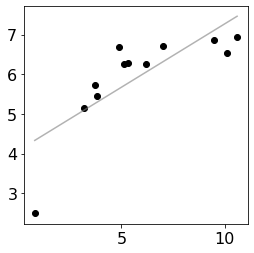

MAE is 1.6137086065726969, and paramaters are OSDS = 7.3710111852494435, pig = 6.69638993934121, Ag = 0.00285539959245969, Nat = 2.579145861374855


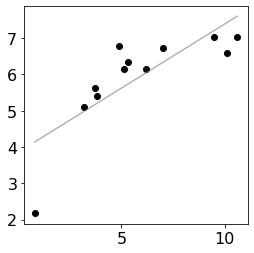

MAE is 1.5533125893844264, and paramaters are OSDS = 7.692698688041, pig = 6.332106858777333, Ag = 0.002896251724500343, Nat = 2.246858654030814


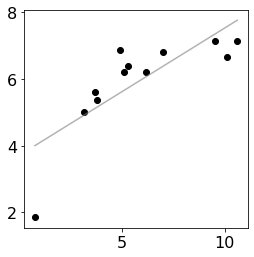

MAE is 1.4971858681423775, and paramaters are OSDS = 7.799862676098716, pig = 6.4878926177075975, Ag = 0.0029582149021622423, Nat = 1.9157447180831069


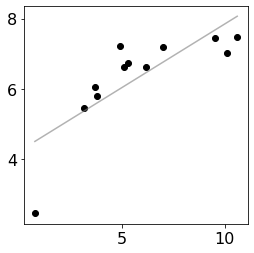

MAE is 1.600896861153423, and paramaters are OSDS = 8.084707011725612, pig = 6.91438151619771, Ag = 0.002428900682054506, Nat = 2.5455628176809517


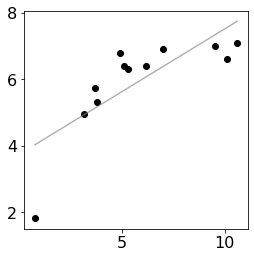

MAE is 1.4902176136924028, and paramaters are OSDS = 7.513408068135959, pig = 7.058418421708991, Ag = 0.0028993797457600393, Nat = 1.8731690071201208


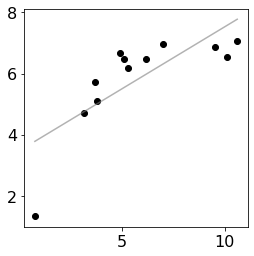

MAE is 1.5042844239711213, and paramaters are OSDS = 7.290829346544161, pig = 7.553863683400909, Ag = 0.0030524605567098188, Nat = 1.3684162772536022


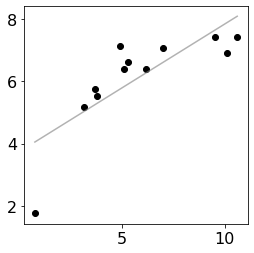

MAE is 1.4865875331446903, and paramaters are OSDS = 8.17216083564933, pig = 6.610570621876822, Ag = 0.002659188353811004, Nat = 1.8237091854710559


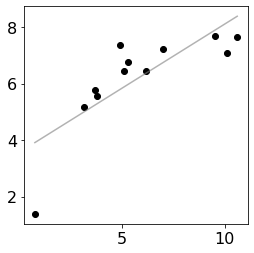

MAE is 1.482654366621509, and paramaters are OSDS = 8.572735660849272, pig = 6.567660963144627, Ag = 0.002561082734486661, Nat = 1.4459908475191563


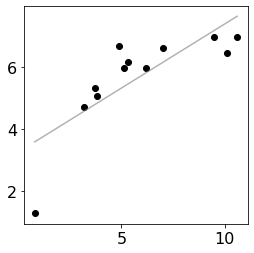

MAE is 1.5321692827265536, and paramaters are OSDS = 7.70247933373499, pig = 6.219218768493781, Ag = 0.003151778290432266, Nat = 1.3075062440840615


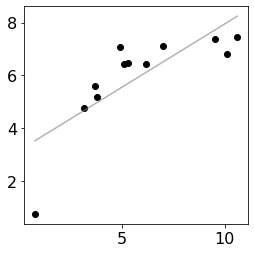

MAE is 1.479481622963374, and paramaters are OSDS = 8.105876583572211, pig = 7.013366818705732, Ag = 0.0030425472738560035, Nat = 0.7999718575955796


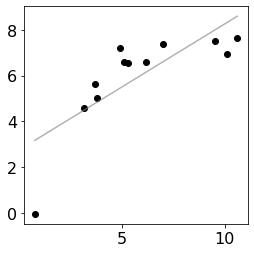

MAE is 1.4725118440858, and paramaters are OSDS = 8.314631732439686, pig = 7.443435944647714, Ag = 0.0031924806295017052, Nat = -0.03565898901045195


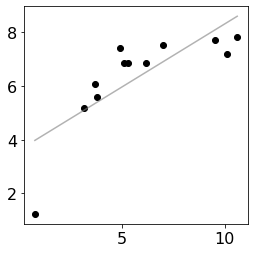

MAE is 1.4806969156265108, and paramaters are OSDS = 8.397839735026826, pig = 7.559485205110684, Ag = 0.002653800715523057, Nat = 1.2921165477719043


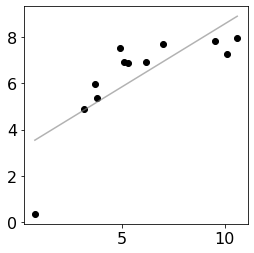

MAE is 1.4734678256912364, and paramaters are OSDS = 8.599444922127159, pig = 7.826607649598412, Ag = 0.0026951570104734885, Nat = 0.3720639886172581


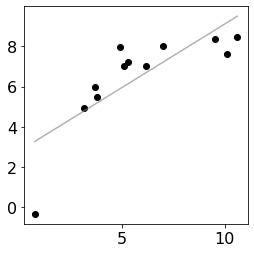

MAE is 1.4670506797691878, and paramaters are OSDS = 9.42891795708551, pig = 7.640176459541726, Ag = 0.002651880799232417, Nat = -0.3359128096711874


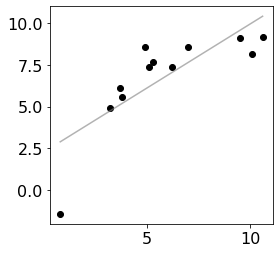

MAE is 1.5717375985398558, and paramaters are OSDS = 10.386672901560285, pig = 7.931055478458095, Ag = 0.0025281313259686057, Nat = -1.4404537180668413


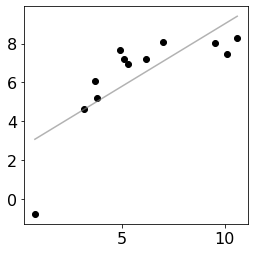

MAE is 1.483182909128124, and paramaters are OSDS = 8.797681512490318, pig = 8.66719166630464, Ag = 0.003035576842878673, Nat = -0.7996864786653948


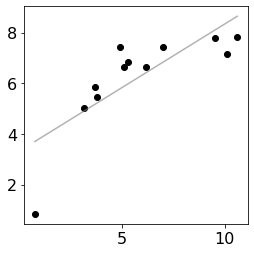

MAE is 1.4779077496098958, and paramaters are OSDS = 8.628972123759533, pig = 7.092543638934631, Ag = 0.002679706261584664, Nat = 0.8845715159730185


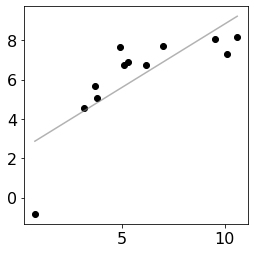

MAE is 1.4642307665617462, and paramaters are OSDS = 9.088143632679119, pig = 7.441896641250557, Ag = 0.0029558116348730804, Nat = -0.8495846948175857


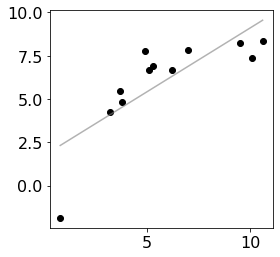

MAE is 1.4559976920293636, and paramaters are OSDS = 9.433295581505266, pig = 7.383102359320494, Ag = 0.003106817094548093, Nat = -1.9204353161123306


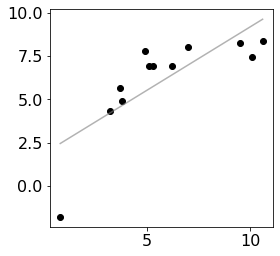

MAE is 1.4574965586759374, and paramaters are OSDS = 9.259172972819277, pig = 8.054117567619542, Ag = 0.0031434615052931877, Nat = -1.8445430790613744


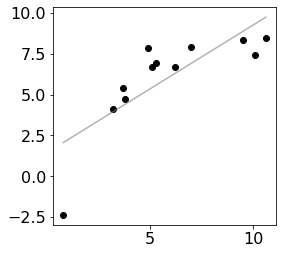

MAE is 1.472123478278599, and paramaters are OSDS = 9.61856419979771, pig = 7.4338085159663265, Ag = 0.003352163003814213, Nat = -2.44033908554493


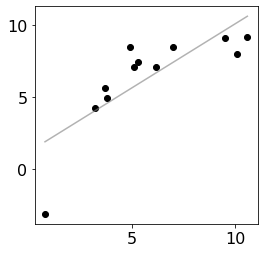

MAE is 1.5242402206388188, and paramaters are OSDS = 10.555343623164195, pig = 7.812166506576331, Ag = 0.00293468057194225, Nat = -3.234956156184459


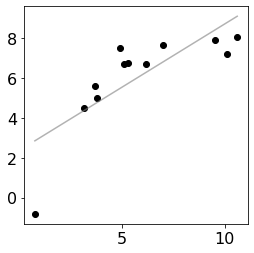

MAE is 1.4649851604881787, and paramaters are OSDS = 8.874809705120814, pig = 7.535618585129868, Ag = 0.003128030615111841, Nat = -0.8354832808039537


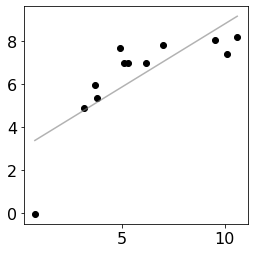

MAE is 1.4697044838924256, and paramaters are OSDS = 8.879533908467721, pig = 7.87269896983949, Ag = 0.002662932003278557, Nat = -0.02784815727949308


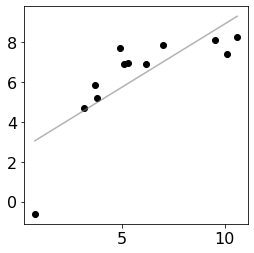

MAE is 1.465229204608115, and paramaters are OSDS = 9.064291481300218, pig = 7.762976356371199, Ag = 0.002835239753412471, Nat = -0.6309708893458523


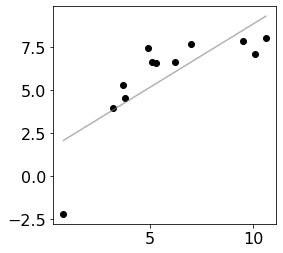

MAE is 1.5490345365952776, and paramaters are OSDS = 8.886866913287278, pig = 7.727730974678826, Ag = 0.00345489368495038, Nat = -2.2798034729905683


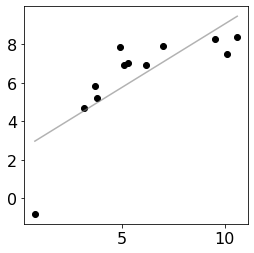

MAE is 1.46326859260901, and paramaters are OSDS = 9.293405196135952, pig = 7.662065088326001, Ag = 0.0028526340206619077, Nat = -0.8218854755010326


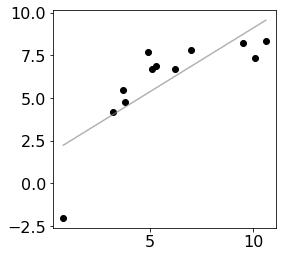

MAE is 1.4599322495089548, and paramaters are OSDS = 9.366050246490436, pig = 7.554475443826753, Ag = 0.003280231864395043, Nat = -2.080202686393493


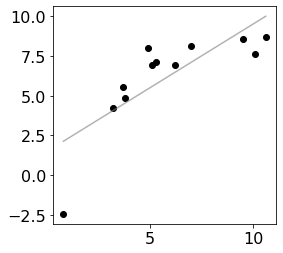

MAE is 1.4732062284946632, and paramaters are OSDS = 9.80115229335465, pig = 7.7912616444165295, Ag = 0.0030635416273372745, Nat = -2.498049997730161


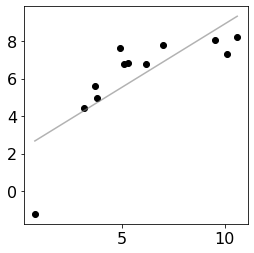

MAE is 1.4612751000285489, and paramaters are OSDS = 9.106395352179273, pig = 7.599529349951533, Ag = 0.0031119083681681995, Nat = -1.2511249600355057


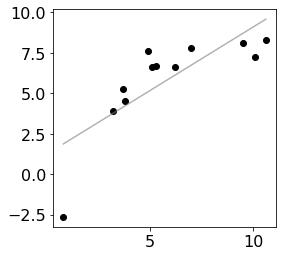

MAE is 1.5477179313449803, and paramaters are OSDS = 9.289051880361177, pig = 7.6335472720331605, Ag = 0.0034685753955403537, Nat = -2.726267545300319


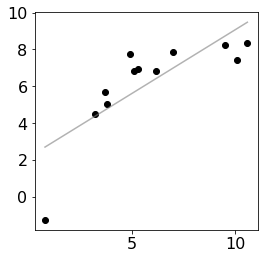

MAE is 1.4601676295164072, and paramaters are OSDS = 9.292316867192259, pig = 7.654935634252791, Ag = 0.003006619364381519, Nat = -1.2979809929508543


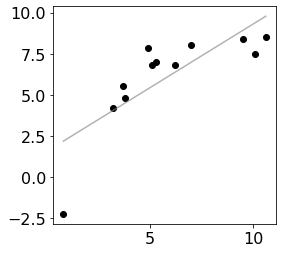

MAE is 1.4525431459108278, and paramaters are OSDS = 9.569022481824344, pig = 7.723786152558258, Ag = 0.0031566565461407215, Nat = -2.3204560772235205


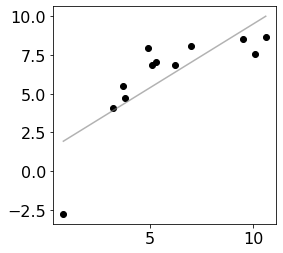

MAE is 1.497121382296613, and paramaters are OSDS = 9.80033604664688, pig = 7.78591455386162, Ag = 0.0031790306351269825, Nat = -2.855121635817528


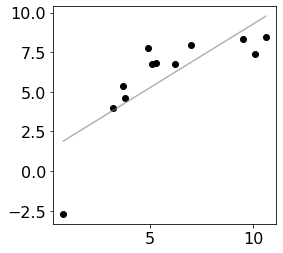

MAE is 1.5159620228659767, and paramaters are OSDS = 9.521453774127405, pig = 7.702805127409732, Ag = 0.0033369641408070036, Nat = -2.7848375864445054


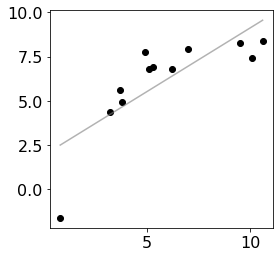

MAE is 1.4574958226619106, and paramaters are OSDS = 9.349601093926045, pig = 7.666903007542026, Ag = 0.0030892055584878903, Nat = -1.669695141324267


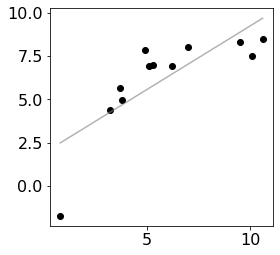

MAE is 1.459614258575116, and paramaters are OSDS = 9.439495818547032, pig = 7.859479099693408, Ag = 0.0029678384878399034, Nat = -1.7973621204672532


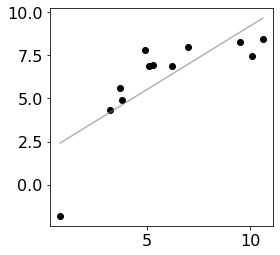

MAE is 1.4557341085912803, and paramaters are OSDS = 9.421134425532884, pig = 7.783228185726744, Ag = 0.003045936831978688, Nat = -1.868072261948813


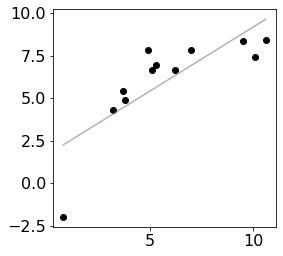

MAE is 1.4547011566346761, and paramaters are OSDS = 9.627353818574994, pig = 7.224392284954218, Ag = 0.003055846510284509, Nat = -2.044786319243091


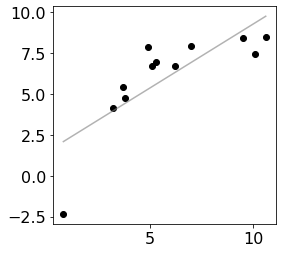

MAE is 1.461484524034889, and paramaters are OSDS = 9.675802059792696, pig = 7.39035148373783, Ag = 0.0030934229329881153, Nat = -2.40717984593961


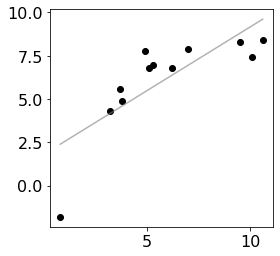

MAE is 1.456090093183244, and paramaters are OSDS = 9.431151335392709, pig = 7.597765126590977, Ag = 0.0030902599021129466, Nat = -1.854066317478103


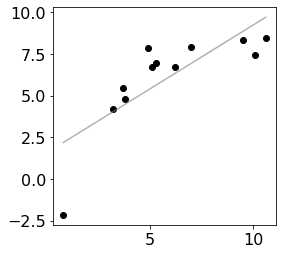

MAE is 1.4532786342259107, and paramaters are OSDS = 9.594251818326033, pig = 7.45948936468888, Ag = 0.003092368589363059, Nat = -2.222808669785774


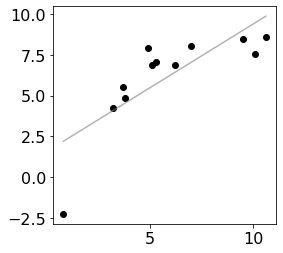

MAE is 1.4603894703457059, and paramaters are OSDS = 9.672585690623862, pig = 7.712345634643556, Ag = 0.0030685871443353963, Nat = -2.3076263479882684


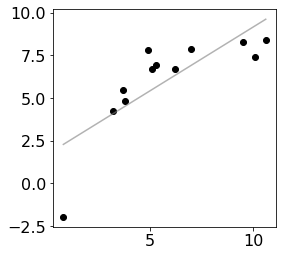

MAE is 1.455001145641539, and paramaters are OSDS = 9.493118108784916, pig = 7.46541317815126, Ag = 0.0030972596069949185, Nat = -2.017233074081315


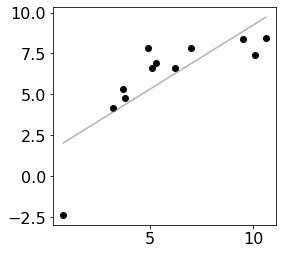

MAE is 1.47006605086818, and paramaters are OSDS = 9.720738688222262, pig = 7.153312304449564, Ag = 0.0031551287944129158, Nat = -2.4345698082180367


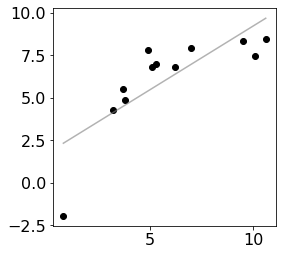

MAE is 1.4547777335537795, and paramaters are OSDS = 9.496035491205228, pig = 7.625749215407449, Ag = 0.003073234822587245, Nat = -2.009696648516119


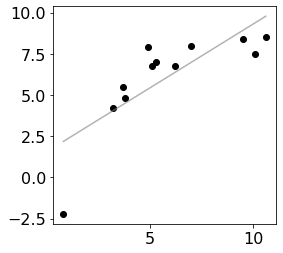

MAE is 1.4525298653471383, and paramaters are OSDS = 9.650213696180383, pig = 7.551295330653143, Ag = 0.0030917936271928495, Nat = -2.281640783302937


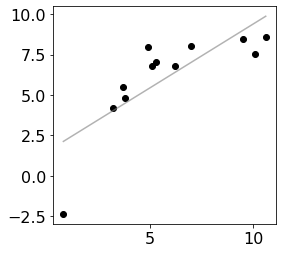

MAE is 1.4551951608217883, and paramaters are OSDS = 9.728761489878117, pig = 7.594236406904086, Ag = 0.003089060637291816, Nat = -2.4138446379137486


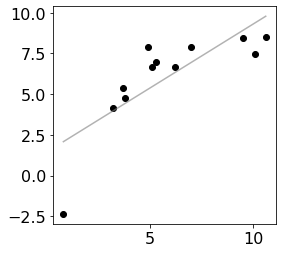

MAE is 1.4581527978043436, and paramaters are OSDS = 9.724385416247648, pig = 7.353732351019801, Ag = 0.0031250978139033244, Nat = -2.4251492762615428


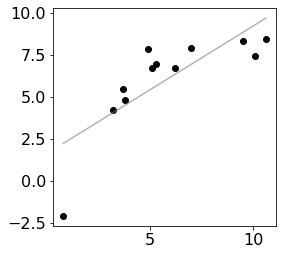

MAE is 1.453990635998229, and paramaters are OSDS = 9.553122972465832, pig = 7.557744999310537, Ag = 0.003086200570416265, Nat = -2.113559805452475


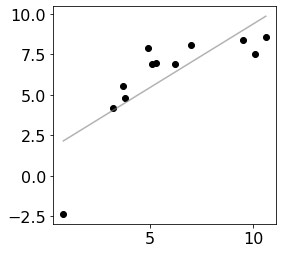

MAE is 1.466948793593635, and paramaters are OSDS = 9.555951665823303, pig = 7.921765638651189, Ag = 0.003157663156271938, Nat = -2.424446348639263


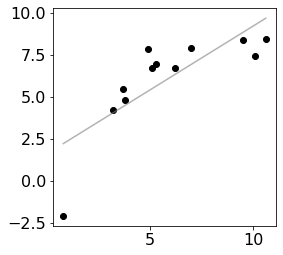

MAE is 1.4538635324591214, and paramaters are OSDS = 9.60950328038707, pig = 7.398735623378461, Ag = 0.003081300671781366, Nat = -2.139701326592134


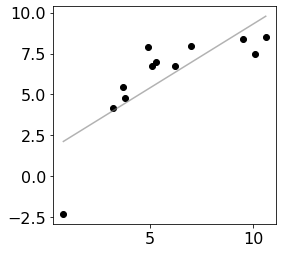

MAE is 1.4536596769561303, and paramaters are OSDS = 9.658372665893083, pig = 7.508908236328833, Ag = 0.003124859146822732, Nat = -2.368743622999708


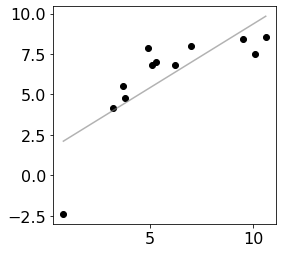

MAE is 1.462090595991329, and paramaters are OSDS = 9.626427050724853, pig = 7.723003918736095, Ag = 0.003151538282978314, Nat = -2.457123250063836


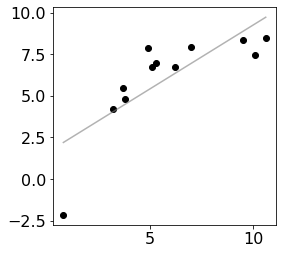

MAE is 1.4531955944714845, and paramaters are OSDS = 9.613734222971516, pig = 7.4798026972178695, Ag = 0.003098860074580603, Nat = -2.2190568074600594


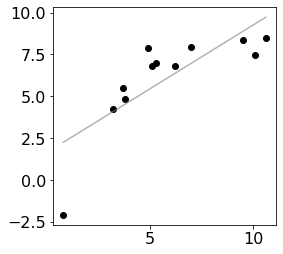

MAE is 1.4536566670044102, and paramaters are OSDS = 9.555238443758057, pig = 7.598278536230242, Ag = 0.0030949802718158843, Nat = -2.1532375458864372


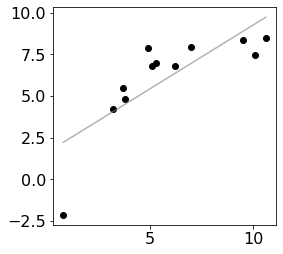

MAE is 1.453241907453145, and paramaters are OSDS = 9.581021999291814, pig = 7.57593596125489, Ag = 0.003102449990567597, Nat = -2.2071140651647547


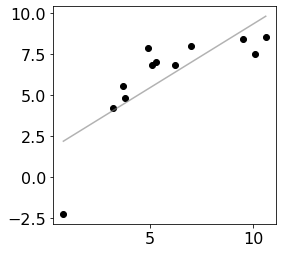

MAE is 1.4553426832338074, and paramaters are OSDS = 9.612744381807996, pig = 7.7059207061532025, Ag = 0.003132511529877826, Nat = -2.2913251967898614


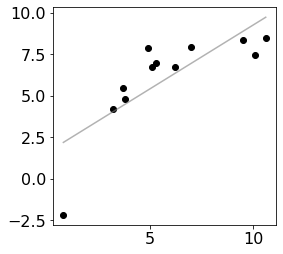

MAE is 1.4530483002173, and paramaters are OSDS = 9.598874959196523, pig = 7.52109720005496, Ag = 0.0031024043244917508, Nat = -2.239937801536796


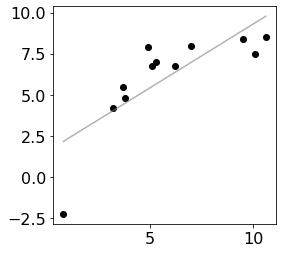

MAE is 1.4522972213463101, and paramaters are OSDS = 9.63490068079457, pig = 7.562054728987226, Ag = 0.003122407295635366, Nat = -2.323431669596902


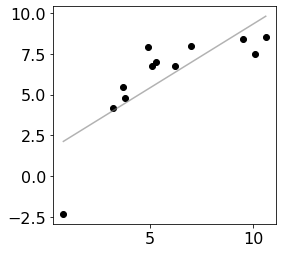

MAE is 1.453086793448527, and paramaters are OSDS = 9.661840021545949, pig = 7.555114112853392, Ag = 0.0031323859481692494, Nat = -2.3815904718129763


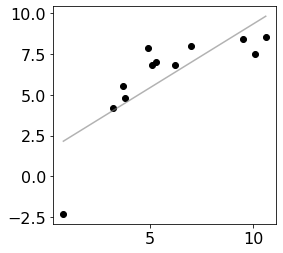

MAE is 1.4540621238549585, and paramaters are OSDS = 9.612771686026395, pig = 7.699314008908924, Ag = 0.0031377708221497404, Nat = -2.3636763583700184


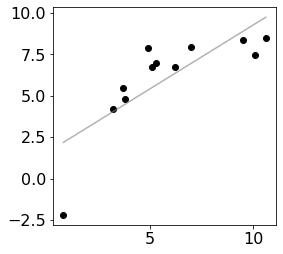

MAE is 1.4528702827949596, and paramaters are OSDS = 9.613493588735235, pig = 7.534680525140633, Ag = 0.0031085877614728877, Nat = -2.2552116951875494


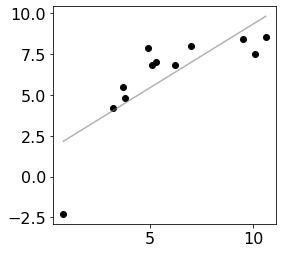

MAE is 1.4533970431344672, and paramaters are OSDS = 9.634940264570742, pig = 7.664811168614669, Ag = 0.0031373182907291613, Nat = -2.350432311118659


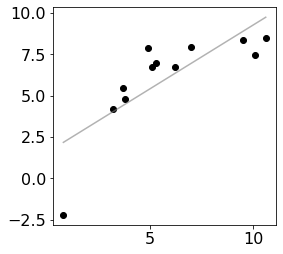

MAE is 1.452774383490075, and paramaters are OSDS = 9.607891285540077, pig = 7.5570256921948875, Ag = 0.0031111328160511034, Nat = -2.267561428932262


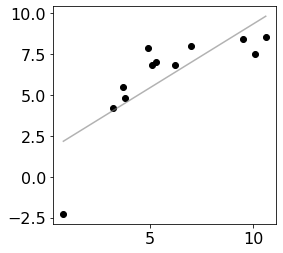

MAE is 1.452082701078296, and paramaters are OSDS = 9.61752048343445, pig = 7.662400427056124, Ag = 0.0031324073810371326, Nat = -2.341333284340262


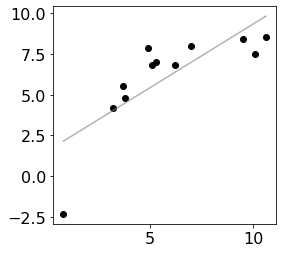

MAE is 1.4564596521517166, and paramaters are OSDS = 9.619533930784058, pig = 7.726260378013869, Ag = 0.003144317190819255, Nat = -2.3843940789166185


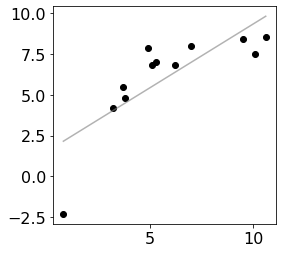

MAE is 1.4544902764415377, and paramaters are OSDS = 9.627937385576796, pig = 7.692742627432487, Ag = 0.003140499608951932, Nat = -2.3658694782995484


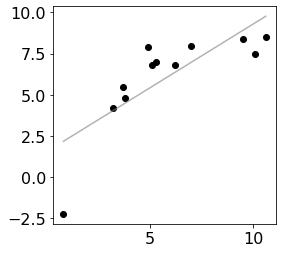

MAE is 1.452538977411879, and paramaters are OSDS = 9.612902810549258, pig = 7.5909549260042875, Ag = 0.0031184745142763103, Nat = -2.2921384412740835


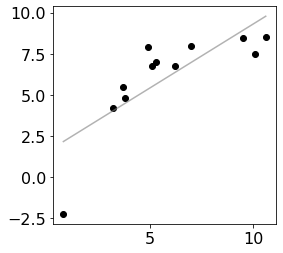

MAE is 1.4524198850288237, and paramaters are OSDS = 9.688746353654988, pig = 7.459566553792131, Ag = 0.003075884862930108, Nat = -2.2988160120335714


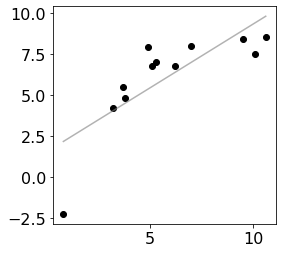

MAE is 1.4521258589884054, and paramaters are OSDS = 9.682787796482938, pig = 7.526703594240025, Ag = 0.0030927720691214175, Nat = -2.3304724333627522


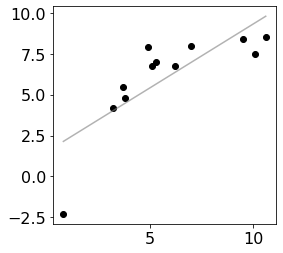

MAE is 1.4521093757743706, and paramaters are OSDS = 9.66176396100309, pig = 7.554067321384609, Ag = 0.0031199421771691627, Nat = -2.3653859163638065


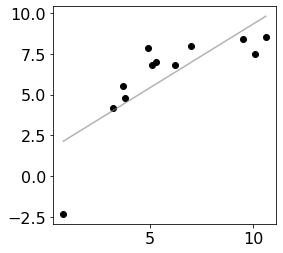

MAE is 1.4546866844631252, and paramaters are OSDS = 9.609740107202537, pig = 7.69304648204186, Ag = 0.003157879598551431, Nat = -2.3814956397982896


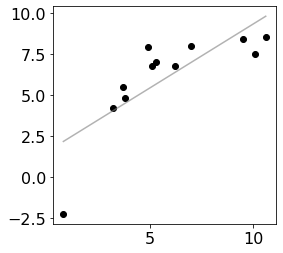

MAE is 1.4522647861752611, and paramaters are OSDS = 9.668994792041875, pig = 7.517936535854563, Ag = 0.0030963835468354388, Nat = -2.3194859189747508


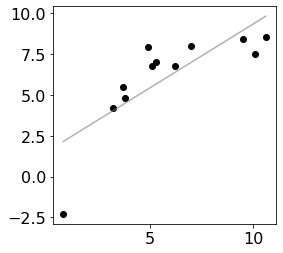

MAE is 1.451905935711561, and paramaters are OSDS = 9.680632835686605, pig = 7.568499210280434, Ag = 0.00309834529144621, Nat = -2.3549071069238834


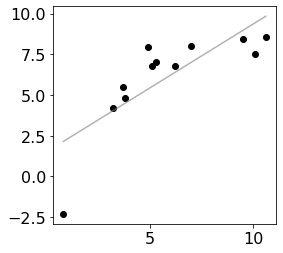

MAE is 1.4522899254688006, and paramaters are OSDS = 9.703498913132623, pig = 7.57172145092704, Ag = 0.0030863142893516327, Nat = -2.370644825587374


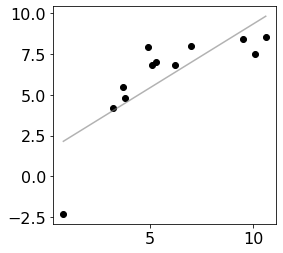

MAE is 1.4525582938524948, and paramaters are OSDS = 9.652357746261668, pig = 7.637898740626033, Ag = 0.003125349912551522, Nat = -2.3765634515206013


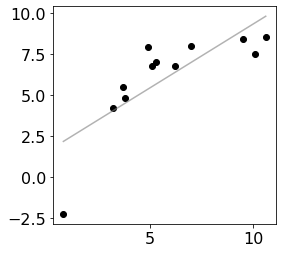

MAE is 1.4521383260441354, and paramaters are OSDS = 9.664835530596823, pig = 7.54792708704743, Ag = 0.0031036251382644594, Nat = -2.3337553021112134


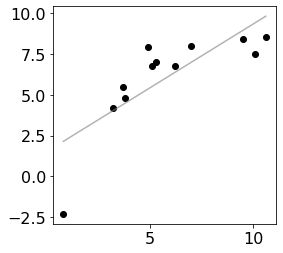

MAE is 1.4518854057818853, and paramaters are OSDS = 9.65651700770672, pig = 7.607908189433166, Ag = 0.0031181083211225015, Nat = -2.3622940683841387


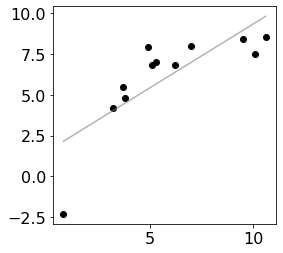

MAE is 1.4525582938524944, and paramaters are OSDS = 9.652357746261668, pig = 7.637898740626035, Ag = 0.0031253499125515234, Nat = -2.3765634515206013


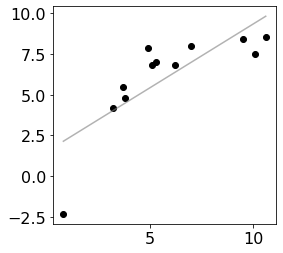

MAE is 1.4537656148285751, and paramaters are OSDS = 9.625429347432497, pig = 7.669733979837141, Ag = 0.0031416295162660854, Nat = -2.3814877546432927


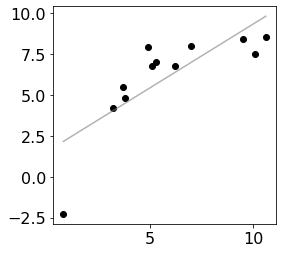

MAE is 1.4520388057998928, and paramaters are OSDS = 9.668448184220328, pig = 7.562461190639304, Ag = 0.0031049864309075845, Nat = -2.3432262636828876


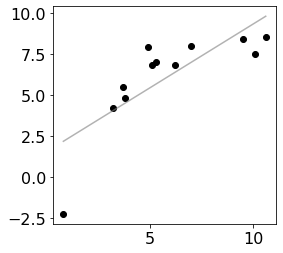

MAE is 1.453596547490659, and paramaters are OSDS = 9.649795294520963, pig = 7.6465671873199055, Ag = 0.0031069815350875515, Nat = -2.3354944453017796


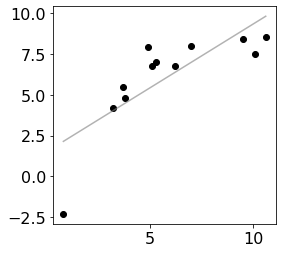

MAE is 1.451955589983344, and paramaters are OSDS = 9.658771794382558, pig = 7.577192287868433, Ag = 0.00311670201664876, Nat = -2.3579130485982995


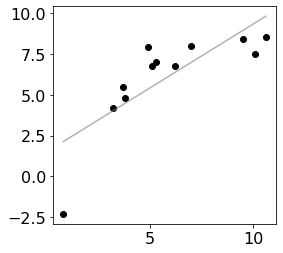

MAE is 1.451810167560045, and paramaters are OSDS = 9.714664427563658, pig = 7.495630012054544, Ag = 0.003086663649025395, Nat = -2.3678369594543422


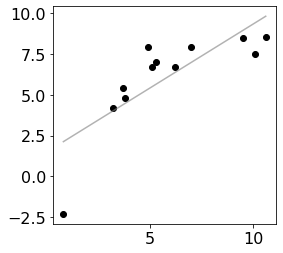

MAE is 1.4516739008009196, and paramaters are OSDS = 9.763236399628262, pig = 7.412244804553755, Ag = 0.0030637917830195257, Nat = -2.3810887970113823


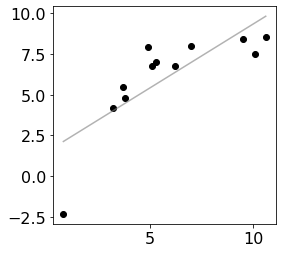

MAE is 1.451671610338962, and paramaters are OSDS = 9.711130834481743, pig = 7.520461055428591, Ag = 0.0030934872752109138, Nat = -2.384875246775965


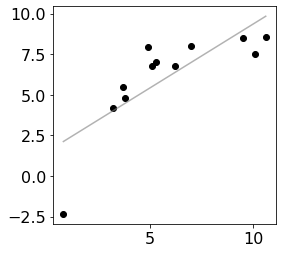

MAE is 1.4514880126084966, and paramaters are OSDS = 9.732472159612449, pig = 7.499460987823234, Ag = 0.0030877376973625775, Nat = -2.405699738322504


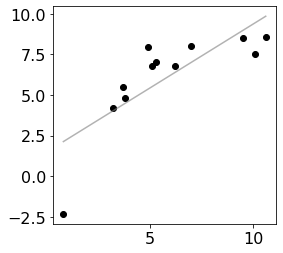

MAE is 1.4515210374680867, and paramaters are OSDS = 9.757657406934458, pig = 7.466864308176861, Ag = 0.0030672895298266474, Nat = -2.394081806722655


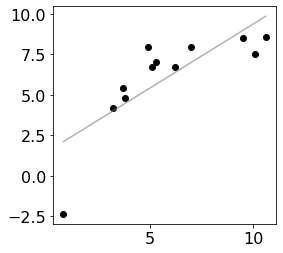

MAE is 1.451378242618133, and paramaters are OSDS = 9.774308651254337, pig = 7.424739934713076, Ag = 0.003070118374219416, Nat = -2.4166750982964564


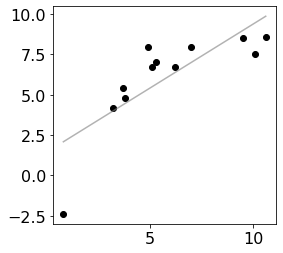

MAE is 1.4511143960714197, and paramaters are OSDS = 9.821146559038205, pig = 7.352860296929396, Ag = 0.003056004915606019, Nat = -2.4475590939827425


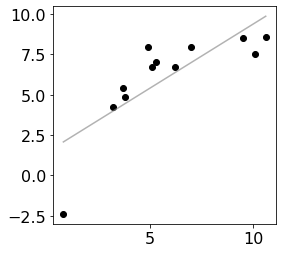

MAE is 1.451013267692576, and paramaters are OSDS = 9.880739254899966, pig = 7.257807009308458, Ag = 0.003019303641784883, Nat = -2.451920649635503


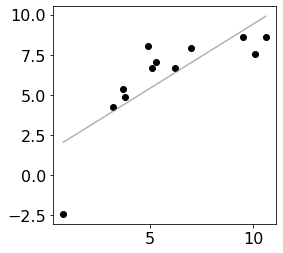

MAE is 1.450577198647921, and paramaters are OSDS = 9.992850378496588, pig = 7.0827564192461026, Ag = 0.002969901302116074, Nat = -2.4967339402611852


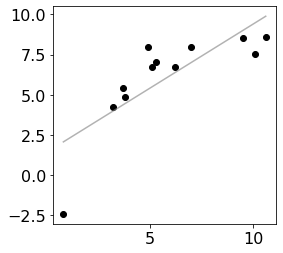

MAE is 1.450676421597043, and paramaters are OSDS = 9.888826852412588, pig = 7.288726201534043, Ag = 0.003026674939436133, Nat = -2.4909484926331613


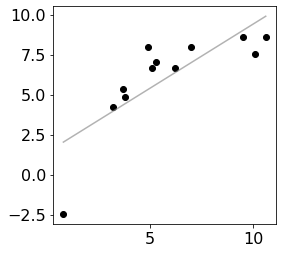

MAE is 1.4504069769943528, and paramaters are OSDS = 9.959990567845457, pig = 7.145037644589527, Ag = 0.0030028698974337545, Nat = -2.5263888258771416


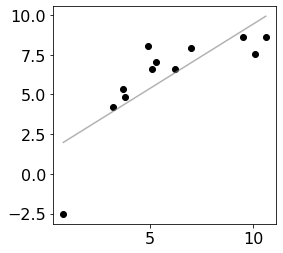

MAE is 1.449849946757486, and paramaters are OSDS = 10.061157148300957, pig = 6.98412431279586, Ag = 0.0029706600812373076, Nat = -2.592542335454385


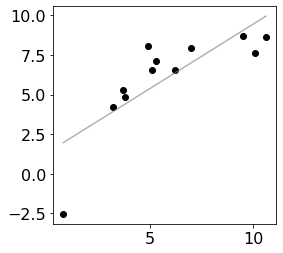

MAE is 1.4496209689284376, and paramaters are OSDS = 10.14951830951172, pig = 6.854772627429467, Ag = 0.002923882921835189, Nat = -2.6081921928432337


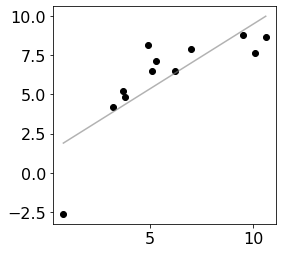

MAE is 1.4486874470884086, and paramaters are OSDS = 10.358041384461355, pig = 6.532428447232583, Ag = 0.0028419555340714955, Nat = -2.7094384201035986


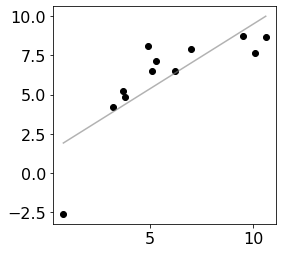

MAE is 1.4487811109740096, and paramaters are OSDS = 10.329291322797538, pig = 6.591157393474898, Ag = 0.0028485910128244855, Nat = -2.6972725002434226


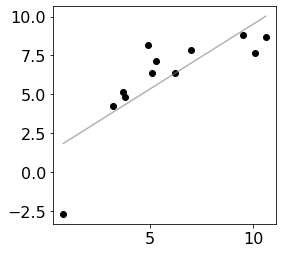

MAE is 1.448271430136869, and paramaters are OSDS = 10.48184326461563, pig = 6.306507084840678, Ag = 0.0027888790256885487, Nat = -2.7570451053981344


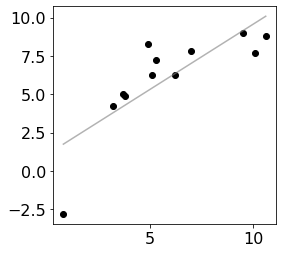

MAE is 1.447068934406783, and paramaters are OSDS = 10.778351470717151, pig = 5.815397526493996, Ag = 0.002669981068814756, Nat = -2.8900934117806205


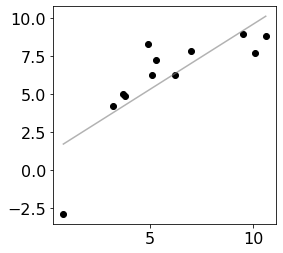

MAE is 1.4466165209654225, and paramaters are OSDS = 10.770570284641913, pig = 5.878797420752566, Ag = 0.002695692546357948, Nat = -2.947939393529829


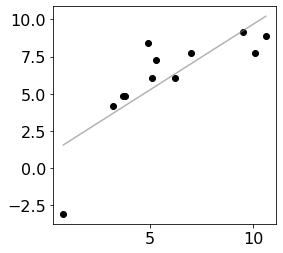

MAE is 1.447101743785608, and paramaters are OSDS = 11.159430237714574, pig = 5.2768179215057955, Ag = 0.002558588168478884, Nat = -3.17354212016415


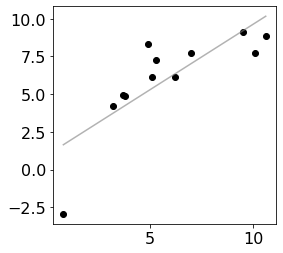

MAE is 1.445727059959826, and paramaters are OSDS = 11.056970083008022, pig = 5.424766081181161, Ag = 0.002557449999797035, Nat = -3.0298295273743507


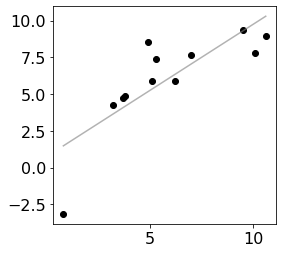

MAE is 1.475307929587639, and paramaters are OSDS = 11.554876550361556, pig = 4.645086965373814, Ag = 0.002350844959076899, Nat = -3.2484731233343336


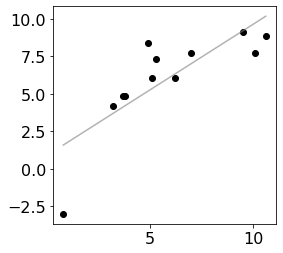

MAE is 1.4495396317296023, and paramaters are OSDS = 11.152675288616685, pig = 5.234537344355255, Ag = 0.0025339485616961317, Nat = -3.0913778761507773


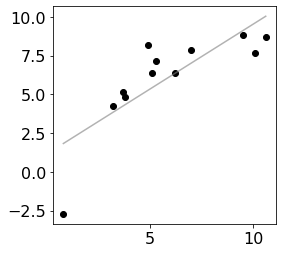

MAE is 1.44790305078956, and paramaters are OSDS = 10.535137314252324, pig = 6.252002381194988, Ag = 0.002769930400042397, Nat = -2.7957988442202613


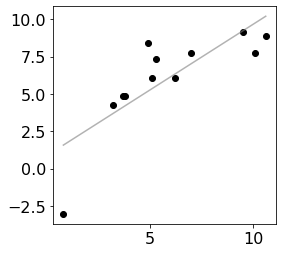

MAE is 1.453001484507543, and paramaters are OSDS = 11.21247319184835, pig = 5.153053257578772, Ag = 0.0025045714734345725, Nat = -3.1223921683489326


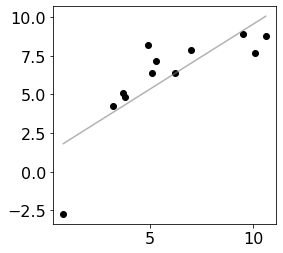

MAE is 1.447758169309403, and paramaters are OSDS = 10.571649336308104, pig = 6.18758464981913, Ag = 0.002757609518912265, Nat = -2.812676857164932


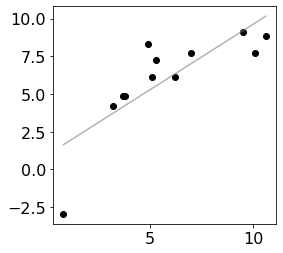

MAE is 1.4456822915311578, and paramaters are OSDS = 11.053633273085271, pig = 5.4012704579284385, Ag = 0.002570436166898605, Nat = -3.0444707507046056


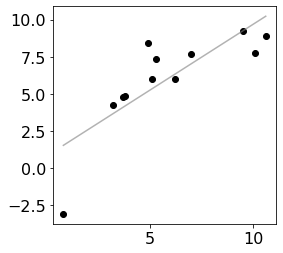

MAE is 1.462031301419801, and paramaters are OSDS = 11.312881252501747, pig = 4.975904496295165, Ag = 0.0024706890503267097, Nat = -3.168806703946778


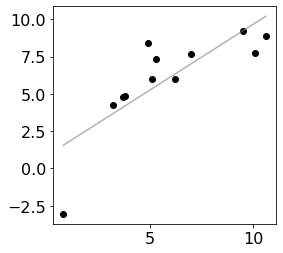

MAE is 1.4571059467403884, and paramaters are OSDS = 11.258113219418073, pig = 5.07253109335895, Ag = 0.002489170372021907, Nat = -3.143489684529771


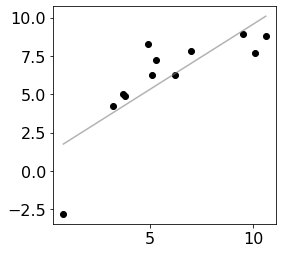

MAE is 1.4470159355126, and paramaters are OSDS = 10.743265307085597, pig = 5.9088212607040855, Ag = 0.0026904997321896755, Nat = -2.895380064006142


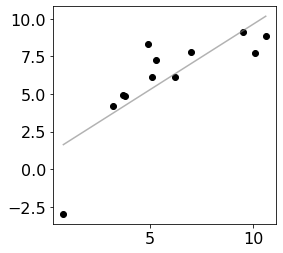

MAE is 1.4454519695777197, and paramaters are OSDS = 11.033868003193252, pig = 5.49143008378913, Ag = 0.002587058153806876, Nat = -3.068716456026843


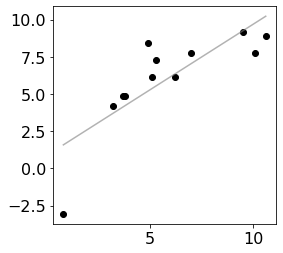

MAE is 1.4446434871631884, and paramaters are OSDS = 11.161626269431302, pig = 5.329446362436698, Ag = 0.002545596696302936, Nat = -3.1580279781499545


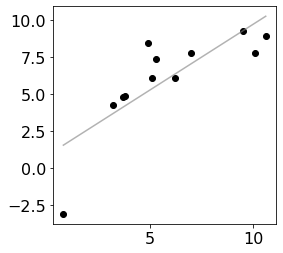

MAE is 1.4538067854822811, and paramaters are OSDS = 11.278134647997657, pig = 5.108318900445347, Ag = 0.0024940879724885865, Nat = -3.194753760873228


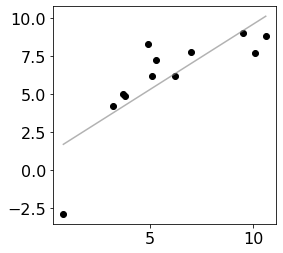

MAE is 1.446341637708749, and paramaters are OSDS = 10.876982642313612, pig = 5.7086956706394005, Ag = 0.0026413967922644032, Nat = -2.9702234882229135


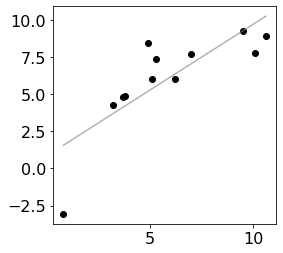

MAE is 1.4559484868101318, and paramaters are OSDS = 11.304035849277192, pig = 5.0532918653402845, Ag = 0.002461747281273541, Nat = -3.153336478696083


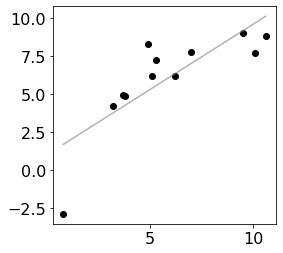

MAE is 1.4461075700280765, and paramaters are OSDS = 10.903936675800733, pig = 5.672421031899495, Ag = 0.0026372062300868463, Nat = -2.9992886648213926


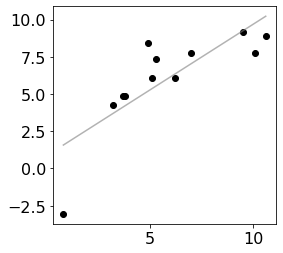

MAE is 1.4492081344221182, and paramaters are OSDS = 11.21110050834905, pig = 5.205256296083498, Ag = 0.002513947754278308, Nat = -3.145584972302238


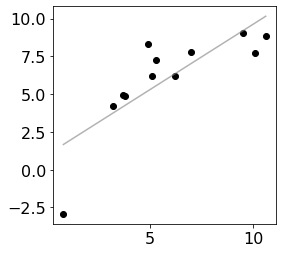

MAE is 1.4459408699396556, and paramaters are OSDS = 10.96051210882247, pig = 5.582835827000425, Ag = 0.0026095345327678795, Nat = -3.0140638592427447


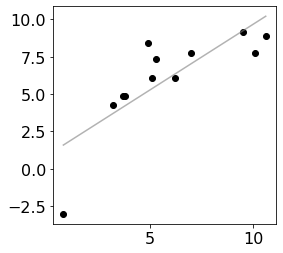

MAE is 1.4494364410375429, and paramaters are OSDS = 11.2124341913728, pig = 5.196738332373866, Ag = 0.002504302467796382, Nat = -3.123907392914435


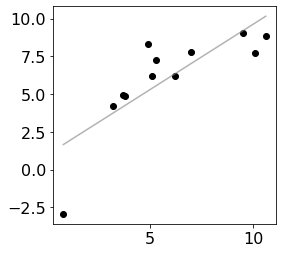

MAE is 1.4458029985882666, and paramaters are OSDS = 10.98106105469375, pig = 5.553500357018088, Ag = 0.00260398028951423, Nat = -3.0304433468446534


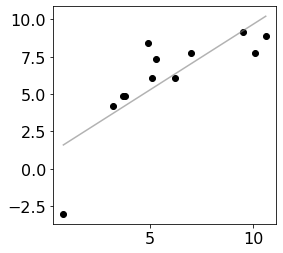

MAE is 1.4460948031704637, and paramaters are OSDS = 11.1661332312867, pig = 5.271655802281769, Ag = 0.002529197043488523, Nat = -3.117321942294037


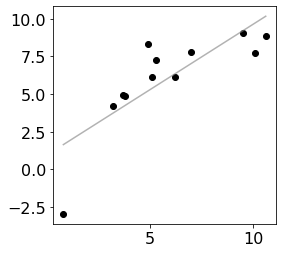

MAE is 1.4457024146251332, and paramaters are OSDS = 11.011917389438528, pig = 5.505040820820761, Ag = 0.0025894501604480404, Nat = -3.0398783800055678


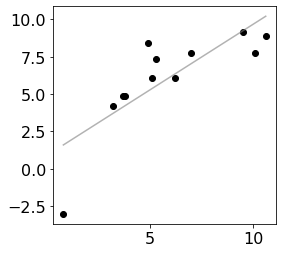

MAE is 1.4457912517447908, and paramaters are OSDS = 11.161012452787812, pig = 5.276761504165442, Ag = 0.002527486222209078, Nat = -3.105659971272586


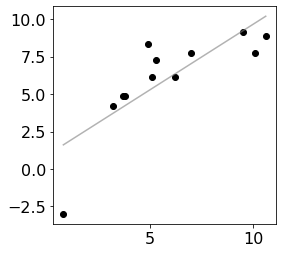

MAE is 1.4452567206856053, and paramaters are OSDS = 11.116024603264295, pig = 5.345946217378604, Ag = 0.0025466097390353663, Nat = -3.086855815165603


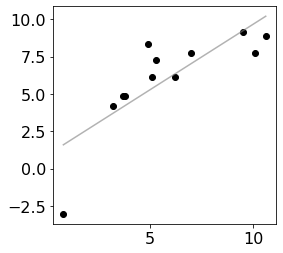

MAE is 1.4449153970427162, and paramaters are OSDS = 11.114630684601678, pig = 5.36608584810109, Ag = 0.0025685963815454387, Nat = -3.134786934638515


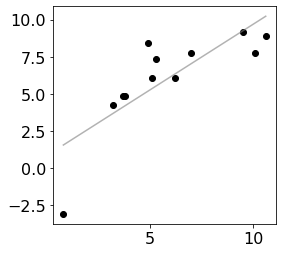

MAE is 1.4487765704274347, and paramaters are OSDS = 11.211040025752746, pig = 5.216333622101653, Ag = 0.0025261693314431325, Nat = -3.172192359323772


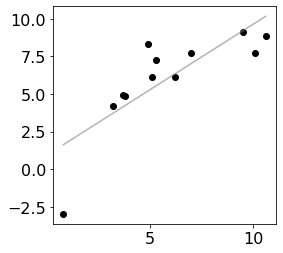

MAE is 1.4454134443653999, and paramaters are OSDS = 11.061698048517083, pig = 5.432864021140984, Ag = 0.002573629953196813, Nat = -3.0729568748351186


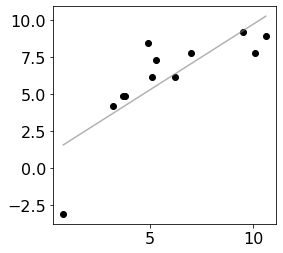

MAE is 1.4444322330972972, and paramaters are OSDS = 11.173356529821906, pig = 5.335900766600249, Ag = 0.0025467802181416716, Nat = -3.1818430506899906


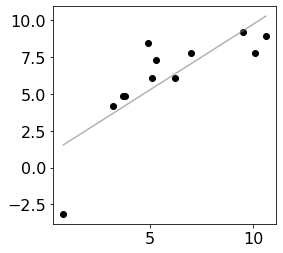

MAE is 1.4438072038803675, and paramaters are OSDS = 11.233218158190219, pig = 5.303215920936154, Ag = 0.002534952243763205, Nat = -3.250529200682683


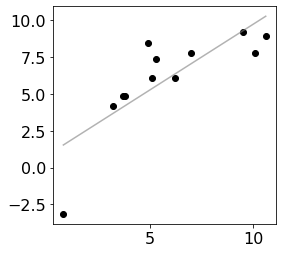

MAE is 1.4455820445806447, and paramaters are OSDS = 11.251051809226663, pig = 5.239483153285288, Ag = 0.00252424757712666, Nat = -3.2421430894832595


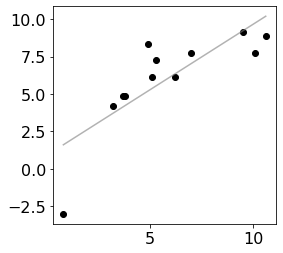

MAE is 1.4450345732791847, and paramaters are OSDS = 11.109036488694478, pig = 5.384518804177061, Ag = 0.002561284359179275, Nat = -3.115253428497154


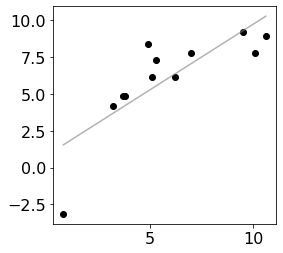

MAE is 1.4440048958060876, and paramaters are OSDS = 11.193231197194544, pig = 5.345687250446897, Ag = 0.002558605101360061, Nat = -3.2424429558185506


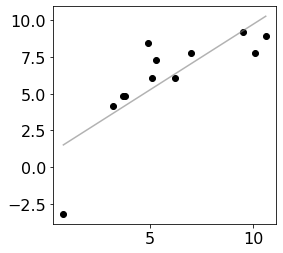

MAE is 1.4438787107934905, and paramaters are OSDS = 11.242316666014393, pig = 5.2876988867833585, Ag = 0.002542590852306545, Nat = -3.277640106147698


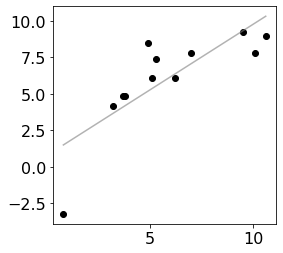

MAE is 1.44320444505812, and paramaters are OSDS = 11.300565460813552, pig = 5.266938362200463, Ag = 0.002522276065320935, Nat = -3.329533185760928


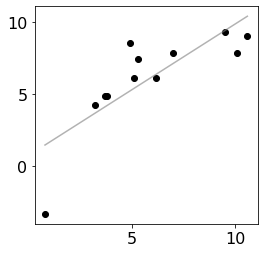

MAE is 1.4434286406602201, and paramaters are OSDS = 11.393532848919492, pig = 5.21736461925015, Ag = 0.002499115907208683, Nat = -3.426906311322135


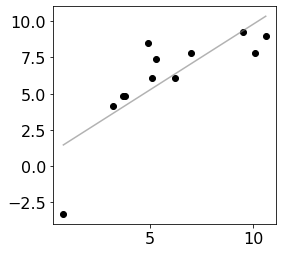

MAE is 1.4452663955136973, and paramaters are OSDS = 11.323039471675049, pig = 5.272323847746737, Ag = 0.0025336154350724368, Nat = -3.3920447460549754


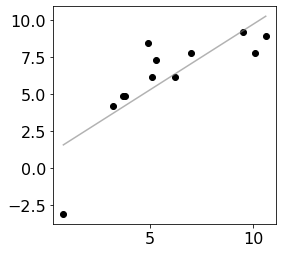

MAE is 1.4441296162064547, and paramaters are OSDS = 11.20197956999224, pig = 5.315165733764208, Ag = 0.002542601380995311, Nat = -3.21653217012621


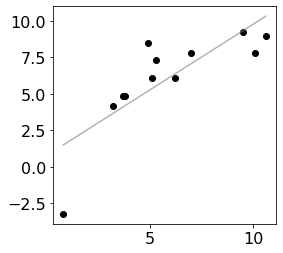

MAE is 1.4443325176231732, and paramaters are OSDS = 11.282686171114111, pig = 5.286604476419227, Ag = 0.002536610750380062, Nat = -3.33354055407872


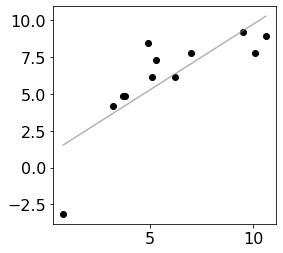

MAE is 1.443872680728087, and paramaters are OSDS = 11.222156220272709, pig = 5.308025419427963, Ag = 0.002541103723341499, Nat = -3.2457842661143372


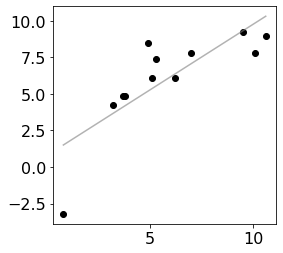

MAE is 1.4434838428206138, and paramaters are OSDS = 11.30589705545089, pig = 5.237252044227073, Ag = 0.002511856341006031, Nat = -3.3093004235342733


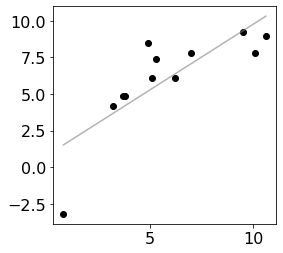

MAE is 1.443391820155055, and paramaters are OSDS = 11.288601781349293, pig = 5.270016986612468, Ag = 0.00251250333440929, Nat = -3.289933431898412


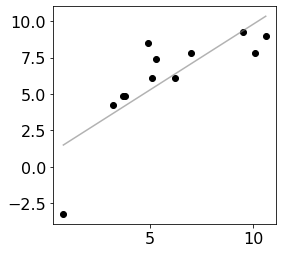

MAE is 1.4428989849029634, and paramaters are OSDS = 11.341985007629269, pig = 5.230686237560116, Ag = 0.0024996902689082313, Nat = -3.3438638548238107


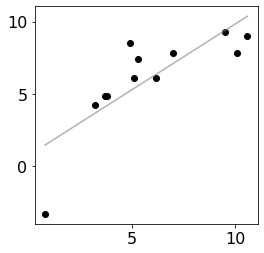

MAE is 1.4426044529110518, and paramaters are OSDS = 11.401899401307546, pig = 5.192016646626193, Ag = 0.0024789835416915975, Nat = -3.392903649178548


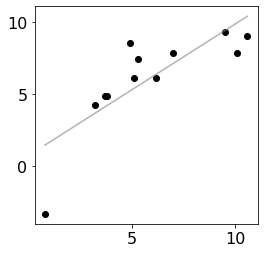

MAE is 1.4430643556876828, and paramaters are OSDS = 11.415263691270422, pig = 5.179896098896945, Ag = 0.0024778573974507216, Nat = -3.410306144503397


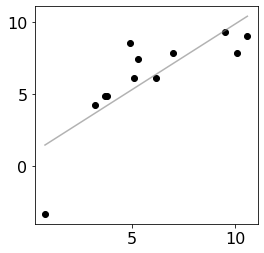

MAE is 1.4423289725372175, and paramaters are OSDS = 11.397268111919514, pig = 5.217182002940962, Ag = 0.002483953828430241, Nat = -3.4020377821363694


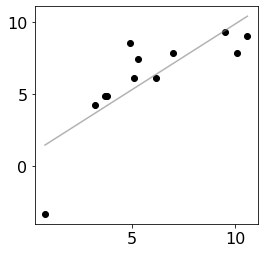

MAE is 1.441867250871926, and paramaters are OSDS = 11.442953640153828, pig = 5.207146982297907, Ag = 0.0024700025721423463, Nat = -3.4484064614374175


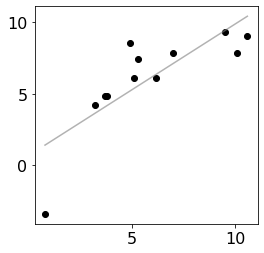

MAE is 1.442752595170006, and paramaters are OSDS = 11.49173931542338, pig = 5.152982058398287, Ag = 0.00246205645389351, Nat = -3.500641288541733


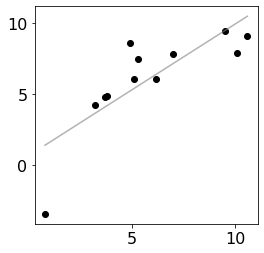

MAE is 1.4419841989315854, and paramaters are OSDS = 11.575362563264036, pig = 5.099082530909204, Ag = 0.0024221739172681526, Nat = -3.5465955860696194


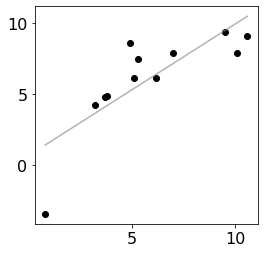

MAE is 1.44103386169433, and paramaters are OSDS = 11.540713768803975, pig = 5.14571801021885, Ag = 0.0024387508450470817, Nat = -3.533967348110262


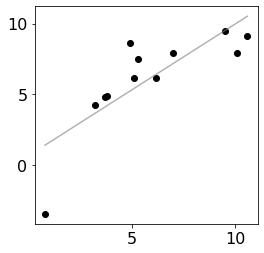

MAE is 1.4404173283886446, and paramaters are OSDS = 11.603438807570754, pig = 5.128628965879802, Ag = 0.0024191975688452622, Nat = -3.5957979499136936


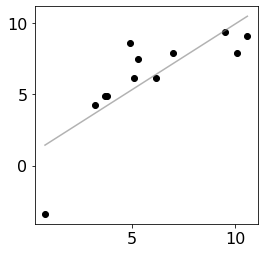

MAE is 1.4413685287817544, and paramaters are OSDS = 11.520087890724703, pig = 5.160455504458266, Ag = 0.0024331223460801695, Nat = -3.4912105347579065


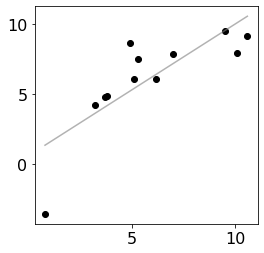

MAE is 1.439861871295428, and paramaters are OSDS = 11.669022049549113, pig = 5.105640345146396, Ag = 0.002393264660476368, Nat = -3.648101616910771


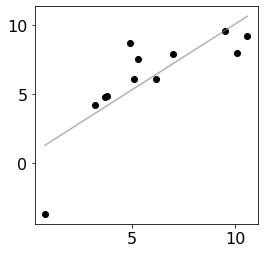

MAE is 1.4385867384479412, and paramaters are OSDS = 11.802583373669897, pig = 5.062452194406497, Ag = 0.0023504052198687533, Nat = -3.775700600776883


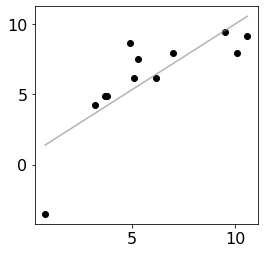

MAE is 1.4402250147157982, and paramaters are OSDS = 11.609169292795556, pig = 5.180259292612032, Ag = 0.002414189936200113, Nat = -3.608962187373331


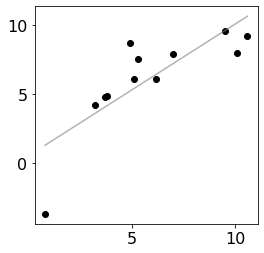

MAE is 1.438431554295143, and paramaters are OSDS = 11.824686042226627, pig = 5.058750996380391, Ag = 0.0023384549633548024, Nat = -3.7874291749734894


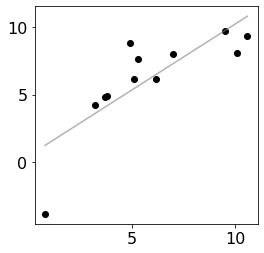

MAE is 1.4382757108215536, and paramaters are OSDS = 12.015552243263024, pig = 4.9845530034216345, Ag = 0.0022726811589610305, Nat = -3.956940531741525


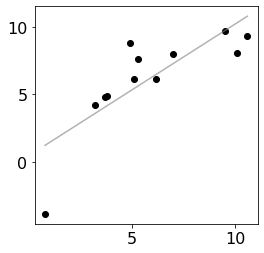

MAE is 1.4389618120450922, and paramaters are OSDS = 11.995283967924912, pig = 5.017491223701716, Ag = 0.00229511459585741, Nat = -3.9774901001448097


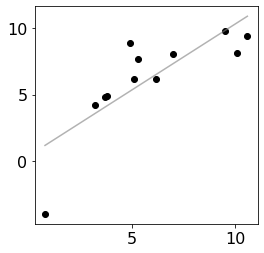

MAE is 1.444710401951616, and paramaters are OSDS = 12.10785563125594, pig = 4.993748891191139, Ag = 0.0022469978865983908, Nat = -4.0637487601045805


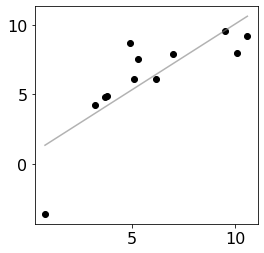

MAE is 1.43922470471536, and paramaters are OSDS = 11.729543013492052, pig = 5.094908947207636, Ag = 0.0023761476482835444, Nat = -3.7127856524614153


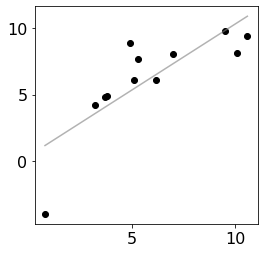

MAE is 1.44207785765894, and paramaters are OSDS = 12.162312006379388, pig = 4.89944339175671, Ag = 0.0022329843752852564, Nat = -4.102496255188985


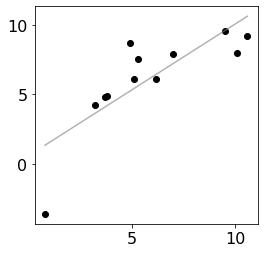

MAE is 1.4390035091288824, and paramaters are OSDS = 11.747454971191514, pig = 5.110055317398201, Ag = 0.0023688885459713987, Nat = -3.7323457043272446


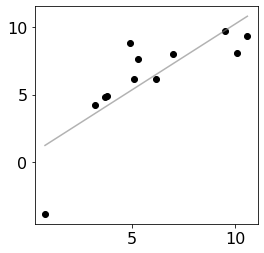

MAE is 1.4408637201150658, and paramaters are OSDS = 12.050894264532623, pig = 4.992366922256388, Ag = 0.002267397112045751, Nat = -4.008452816033815


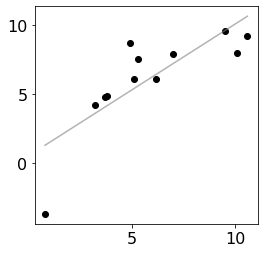

MAE is 1.4384757046803536, and paramaters are OSDS = 11.809880826252193, pig = 5.069273440969824, Ag = 0.002348960014224096, Nat = -3.7867024433545153


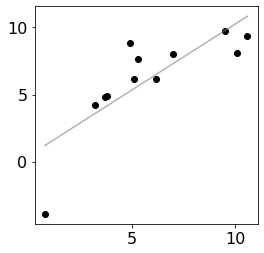

MAE is 1.4393956807757438, and paramaters are OSDS = 12.0641952343635, pig = 4.9568296138516335, Ag = 0.002264691948484246, Nat = -4.016071133681622


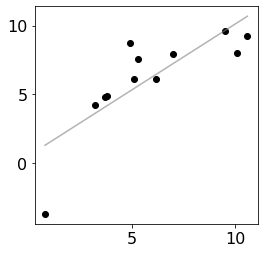

MAE is 1.4382991313310487, and paramaters are OSDS = 11.82664003698451, pig = 5.071748891511559, Ag = 0.0023428393965996106, Nat = -3.803277061665839


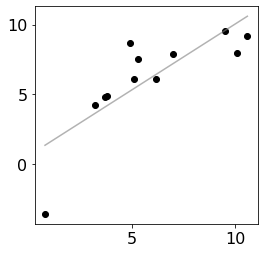

MAE is 1.4394347752352343, and paramaters are OSDS = 11.7320442721599, pig = 5.076522541453041, Ag = 0.0023623282989693353, Nat = -3.683820218624571


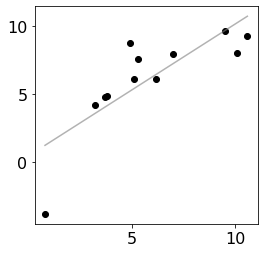

MAE is 1.4373108425571683, and paramaters are OSDS = 11.92947404398366, pig = 5.032249053139548, Ag = 0.002311918021635391, Nat = -3.90407262976475


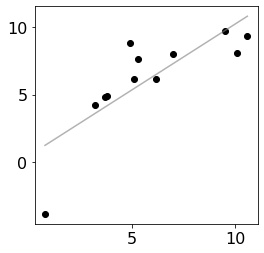

MAE is 1.4383444007435546, and paramaters are OSDS = 11.988190201571797, pig = 5.016460000114787, Ag = 0.0022877940758413108, Nat = -3.9497957324864315


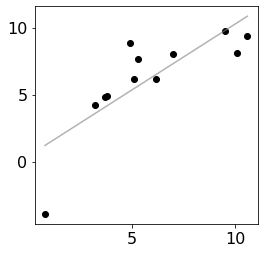

MAE is 1.4416079714881758, and paramaters are OSDS = 12.0700474366493, pig = 4.983232033123939, Ag = 0.0022586563122945756, Nat = -4.020340534474757


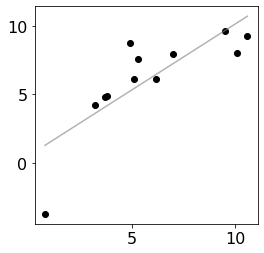

MAE is 1.4378799315570128, and paramaters are OSDS = 11.87492247885147, pig = 5.0477630890083525, Ag = 0.002326384088741716, Nat = -3.845111966134576


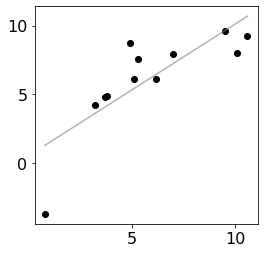

MAE is 1.4382888518862709, and paramaters are OSDS = 11.835104199969535, pig = 5.0516970184257595, Ag = 0.002339117257127563, Nat = -3.804905362166914


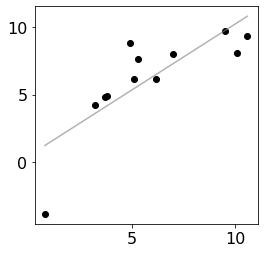

MAE is 1.4372827257514367, and paramaters are OSDS = 12.000886446049332, pig = 4.986382190486088, Ag = 0.0022822108666332402, Nat = -3.9522381832380438


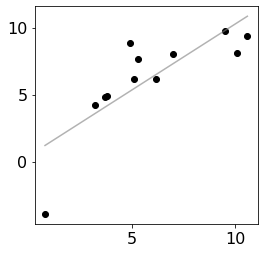

MAE is 1.440265758997472, and paramaters are OSDS = 12.088009650581746, pig = 4.943698839973353, Ag = 0.002251896601650055, Nat = -4.026718744024146


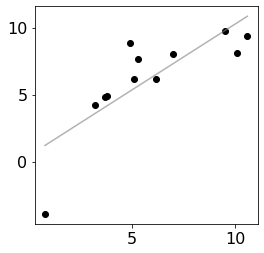

MAE is 1.4413274339895885, and paramaters are OSDS = 12.075313406104208, pig = 4.973776649602051, Ag = 0.002257479810858126, Nat = -4.024276293272534


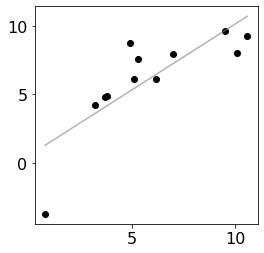

MAE is 1.437732177792321, and paramaters are OSDS = 11.895156501503203, pig = 5.032216926219832, Ag = 0.002318707895560204, Nat = -3.8597480949433187


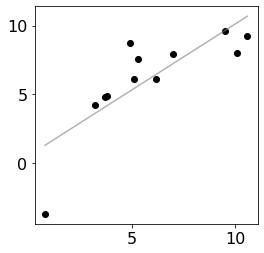

MAE is 1.4384439614878726, and paramaters are OSDS = 11.834667491930809, pig = 5.064752626005276, Ag = 0.0023469292773242454, Nat = -3.8236449052988197


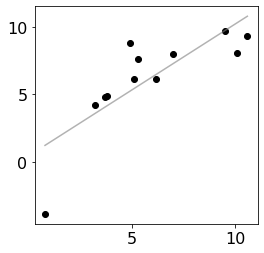

MAE is 1.437071913825758, and paramaters are OSDS = 11.97033105542997, pig = 5.004602909067545, Ag = 0.002291243188551834, Nat = -3.9236166251308484


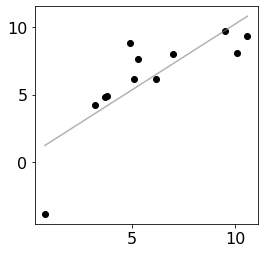

MAE is 1.4382845731047762, and paramaters are OSDS = 12.023001544631612, pig = 4.979962450448154, Ag = 0.0022756558974486186, Nat = -3.9747258004039043


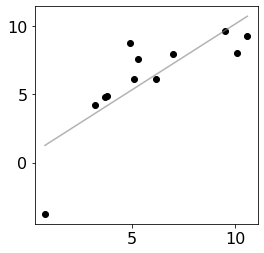

MAE is 1.4375540243844822, and paramaters are OSDS = 11.911942245296505, pig = 5.030812929368302, Ag = 0.0023137020409184418, Nat = -3.877515424701908


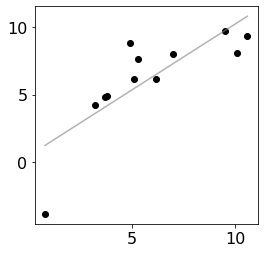

MAE is 1.4384274936149541, and paramaters are OSDS = 12.011160393876528, pig = 4.994806614810909, Ag = 0.0022808291633092496, Nat = -3.9689733364744564


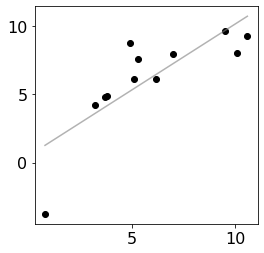

MAE is 1.4374578783261558, and paramaters are OSDS = 11.924157474596534, pig = 5.022864348367602, Ag = 0.0023092382124974653, Nat = -3.8870544053261034


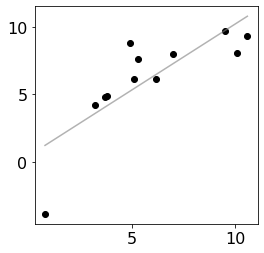

MAE is 1.4375903697435148, and paramaters are OSDS = 12.000482264733243, pig = 4.992236321162089, Ag = 0.002283603103740524, Nat = -3.955975497027964


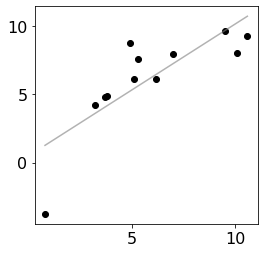

MAE is 1.4373567833649454, and paramaters are OSDS = 11.934077250155688, pig = 5.021168777316749, Ag = 0.0023061773066239623, Nat = -3.897130442783422


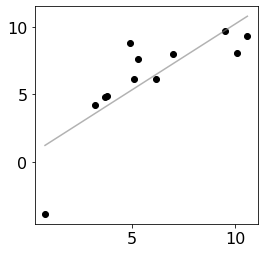

MAE is 1.4375571895146735, and paramaters are OSDS = 11.993226923212791, pig = 4.9993371166373635, Ag = 0.0022865364792247485, Nat = -3.951474535132429


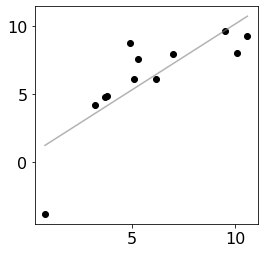

MAE is 1.437296073465631, and paramaters are OSDS = 11.941424836750599, pig = 5.016982540435042, Ag = 0.002303562779179286, Nat = -3.903159437777685


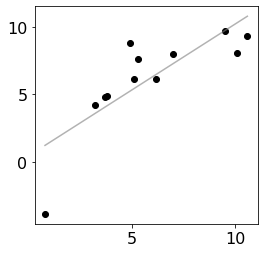

MAE is 1.4371344800503483, and paramaters are OSDS = 11.986980940951092, pig = 4.998939569247362, Ag = 0.0022882901213759133, Nat = -3.9444129951722413


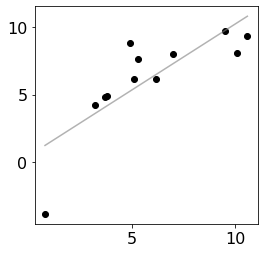

MAE is 1.4377415781267118, and paramaters are OSDS = 12.020337595606836, pig = 4.97120455147847, Ag = 0.0022707354562347456, Nat = -3.9576409908946593


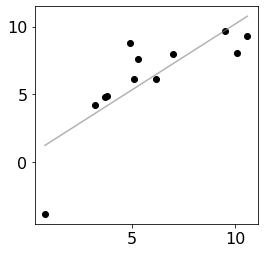

MAE is 1.4371612863860277, and paramaters are OSDS = 11.952189931889453, pig = 5.016987927724278, Ag = 0.0023016223802852297, Nat = -3.917464720047227


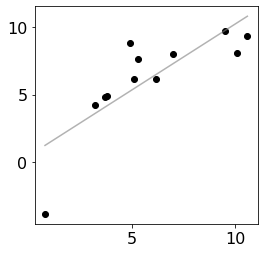

MAE is 1.4381222917915728, and paramaters are OSDS = 12.013769350409326, pig = 4.9864737578275955, Ag = 0.0022781204992438227, Nat = -3.965706824016495


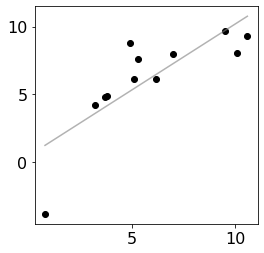

MAE is 1.4371370534553094, and paramaters are OSDS = 11.959510965165281, pig = 5.009355344783181, Ag = 0.0022972022091954205, Nat = -3.9187962843373874


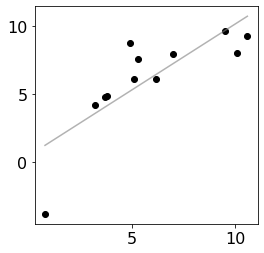

MAE is 1.4373282916087995, and paramaters are OSDS = 11.933620000668565, pig = 5.028560684925095, Ag = 0.002306968083070958, Nat = -3.8999071291058085


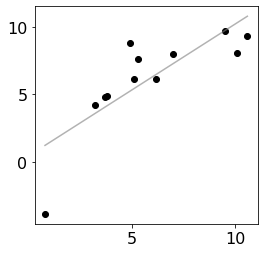

MAE is 1.4369302239066153, and paramaters are OSDS = 11.98406983470414, pig = 4.99692681409584, Ag = 0.0022884001707426695, Nat = -3.939155419704985


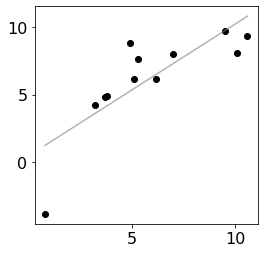

MAE is 1.4372811332143254, and paramaters are OSDS = 11.998256466235787, pig = 4.987924390872687, Ag = 0.0022809454646476883, Nat = -3.9455259421255047


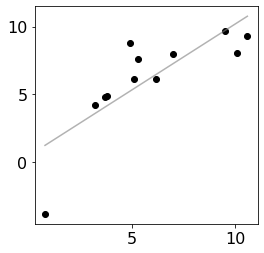

MAE is 1.437083216953426, and paramaters are OSDS = 11.963706565476038, pig = 5.00972204351138, Ag = 0.0022964531513758445, Nat = -3.9244800255667966


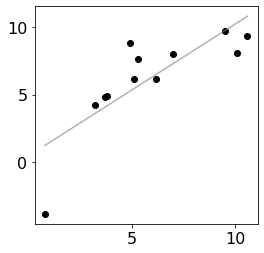

MAE is 1.4373663452245993, and paramaters are OSDS = 11.993033233115339, pig = 4.995740323177882, Ag = 0.00228499110682771, Nat = -3.9470362484500483


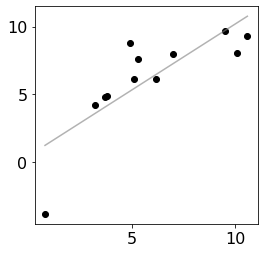

MAE is 1.4370643709253308, and paramaters are OSDS = 11.967891532152795, pig = 5.005951589381857, Ag = 0.002294149433603493, Nat = -3.9258562753655526


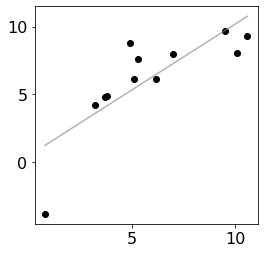

MAE is 1.4371934639099544, and paramaters are OSDS = 11.956018552930377, pig = 5.009662108780949, Ag = 0.0022968328507610067, Nat = -3.9121411777118507


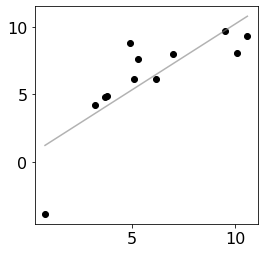

MAE is 1.436959415149196, and paramaters are OSDS = 11.979240343945914, pig = 5.001620204130759, Ag = 0.0022904258037221865, Nat = -3.9363450408071436


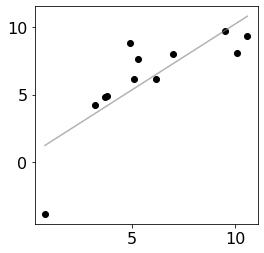

MAE is 1.4369620303297566, and paramaters are OSDS = 11.987059817640372, pig = 4.99482871482662, Ag = 0.0022856561469342465, Nat = -3.9380066549374684


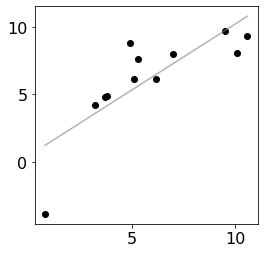

MAE is 1.4369910253835618, and paramaters are OSDS = 11.988799708791642, pig = 4.995060752149994, Ag = 0.0022880725889494642, Nat = -3.9460650702767257


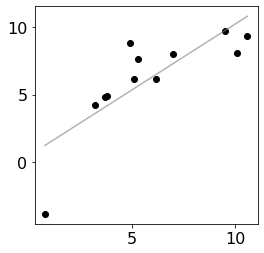

MAE is 1.4374501867692786, and paramaters are OSDS = 12.001693320388238, pig = 4.9882666532197515, Ag = 0.0022821279215707903, Nat = -3.9539298174976083


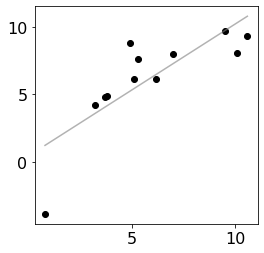

MAE is 1.4369933539183732, and paramaters are OSDS = 11.976341979211655, pig = 5.00153035534133, Ag = 0.0022911440555953176, Nat = -3.9328746608985665


 final_simplex: (array([[11.98406983,  4.99692681,  0.0022884 , -3.93915542],
       [11.97924034,  5.0016202 ,  0.00229043, -3.93634504],
       [11.98705982,  4.99482871,  0.00228566, -3.93800665],
       [11.98879971,  4.99506075,  0.00228807, -3.94606507],
       [11.97634198,  5.00153036,  0.00229114, -3.93287466]]), array([1.43693022, 1.43695942, 1.43696203, 1.43699103, 1.43699335]))
           fun: 1.4369302239066153
       message: 'Optimization terminated successfully.'
          nfev: 252
           nit: 146
        status: 0
       success: True
             x: array([11.98406983,  4.99692681,  0.0022884 , -3.93915542])

In [16]:
d15_obs = pd.read_csv(os.path.join("..", 'Raw_data', 'Tabular',   'Aug2018_water_d15N.csv'))
d15_obs = d15_obs[['Uniqe_ID', 'Measured_D15N', 'D15N_Type']]
Optomo_frame4 = Optomo_frame3.merge(d15_obs, on = "Uniqe_ID", how = 'inner')

#Set to stream or reef of both
Optomo_frame4 = Optomo_frame4[Optomo_frame4['D15N_Type']!= "Stream"]

f_OSDS = Optomo_frame4['OSDS_ShulerLoad']/Optomo_frame4['Total_ShulerLoad']
f_Pig = Optomo_frame4['PIG_ShulerLoad']/Optomo_frame4['Total_ShulerLoad']
f_AG = Optomo_frame4['AG_ShulerLoad']/Optomo_frame4['Total_ShulerLoad']
f_Nat= Optomo_frame4['NAT_ShulerLoad']/Optomo_frame4['Total_ShulerLoad']



def D15NModel(params):
   # this changes the coefficient(s)

    D_OSDS, D_Pig, D_AG, D_Nat = params 

    Optomo_frame4['predicted_D15N_permil'] = (f_OSDS*D_OSDS + f_Pig*D_Pig + f_AG*D_AG + f_Nat*D_Nat)
        
    y_obs = Optomo_frame4["predicted_D15N_permil"]
    x = Optomo_frame4["Measured_D15N"]
       
 
    
    
    return x, y_obs


def optomizod15N(params):
    
    x = D15NModel(params)[0]
    y_obs = D15NModel(params)[1]
    
    
    
    
####### Use to print graphs    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(x, y_obs, label ="", color='k')
    
    #    # plop on a regression line
    mask = ~np.isnan(x) & ~np.isnan(y_obs) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y_obs[mask])   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2
    rX = np.linspace(min(x[mask]), max(x[mask]), 50)
    rY = slope*rX + intercept
    ax.plot(rX,rY, color='grey', linestyle='-', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%1 +"\n Error="+"$%.2f$"%std_err) ) 
    plt.show()
#### comment out if no want show graph
    
    
    
    
    # this is the error part of the function
    desired_slope = 1
    desired_int = 1
    y_mod = desired_slope * x + desired_int
    err_series =  y_mod - y_obs  # ( y = mX+b  minus observed Ys) 
    MAE = abs(err_series).mean()    
    
    print("MAE is {}, and paramaters are OSDS = {}, pig = {}, Ag = {}, Nat = {}".format(MAE, params[0], params[1], params[2], params[3] ))
    
    return MAE

results = opt.minimize(optomizod15N, x0= [9, 14, 0, 4], method="Nelder-Mead",tol = 0.01)
results


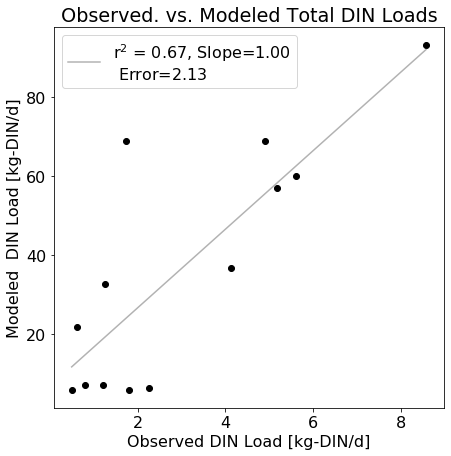

In [17]:
plt.rcParams.update({'font.size': 16})

x, y = LoadModel([ results['x'][0], results['x'][1], results['x'][2] ])

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x, y, label ="", color='k')
ax.set_xlabel("Observed DIN Load [kg-DIN/d]", color='k') 
ax.set_ylabel("Modeled  DIN Load [kg-DIN/d]", color='k')

#    # plop on a regression line
mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
r2 = r_value**2
rX = np.linspace(min(x[mask]), max(x[mask]), 50)
rY = slope*rX + intercept
ax.plot(rX,rY, color='grey', linestyle='-', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%1 +"\n Error="+"$%.2f$"%std_err) )   
ax.legend(loc=2) 
plt.title("Observed. vs. Modeled Total DIN Loads")

plt.savefig(os.path.join(fig_path, "Final_plot1.png"), dpi = 300)

### 10) Save Final Data files

In [18]:
# stick on a geometry column to make the shapefile have shapes
bounds = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "Basin_boundaries.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
Final_shp = bounds.merge(Optomo_frame3, on='Uniqe_ID', how='left')

Final_shp.to_file(os.path.join(Output, 'Final_loading_model3_fixed.shp'),driver ='ESRI Shapefile') 
Optomo_frame3.to_csv(os.path.join(Output, 'Final_loading_model3_fixed.csv'))


# make a shoreline frame
perims = geopandas.read_file(os.path.join("..", "Raw_data", "GIS",  "Sub_basin_perimeters.shp"))   # open up perimiters file
# merge on the desired cols
Final_shp_perims = perims.merge(Optomo_frame3, on='Uniqe_ID', how='outer')
# send to shapefile
Final_shp_perims.to_file(os.path.join(Output, 'Final_loading_model3_fixed_coastline.shp'),driver ='ESRI Shapefile') 


# Prioritization_frame  shapefle of basin prioritization ranks
RANK_shp = bounds.merge(Prioritization_frame, on='Uniqe_ID', how='left')
RANK_shp.to_file(os.path.join(Output, 'Final_Rank3_fixed_testold.shp'),driver ='ESRI Shapefile') 

### 11) Print specific results in notebook for users direct information

In [16]:
# This prints out the total loading for the whole island from each source  

# look at the total percent of the total loading from each WB component in those sheds with all of the components measured
Optomo_frame3['BF_pct_o_Total_load'] =  Optomo_frame3['BF_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 
Optomo_frame3['RO_pct_o_Total_load'] =  Optomo_frame3['RO_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 
Optomo_frame3['SGD_pct_o_Total_load'] =  Optomo_frame3['SGD_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 

# print out here in notebook
print("OSDS load is {} kg/d".format(Optomo_frame3['OSDS_ShulerLoad'].sum()))
print("PIG load is {} kg/d".format(Optomo_frame3['PIG_ShulerLoad'].sum()))
print("Ag load is {} kg/d".format(Optomo_frame3['AG_ShulerLoad'].sum()))
print("NAT load is {} kg/d".format(Optomo_frame3['NAT_ShulerLoad'].sum()))
print("Total load is {} kg/d".format(Optomo_frame3['Total_ShulerLoad'].sum()))

OSDS load is 259.97340616190326 kg/d
PIG load is 111.71093525853075 kg/d
Ag load is 6.262614866965644 kg/d
NAT load is 33.991355995652704 kg/d
Total load is 411.9383122830524 kg/d


In [17]:
# This prints out a comparison of SWB calculated SGD flux and measured SGD rates from Shuler et al. (2019)

# Rn Algae observations
pSGD= 76.9 ; pSGD_ERR= 46.3 
fSGD= 3.00; fSGD_ERR= 1.15
vSGD= 1.13 ; vSGD_ERR= .04 
oSGD= 0.42 ; oSGD_ERR= 0.15 

pBF = 0.33 ; pBF_ERR = 0.18 
fBF = 0.33 ; fBF_ERR = 0.17 
vBF = 0.28 ; vBF_ERR = 0.33 

pDIN_Rn_algae = pSGD + pBF ; pDIN_Rn_algae_ERR = add_err(pSGD_ERR , pBF_ERR )
fDIN_Rn_algae = fSGD + fBF ; fDIN_Rn_algae_ERR = add_err(fSGD_ERR , fBF_ERR )
vDIN_Rn_algae = vSGD + vBF ; vDIN_Rn_algae_ERR = add_err(vSGD_ERR , vBF_ERR )
oDIN_Rn_algae = oSGD       ; oDIN_Rn_algae_ERR = oSGD_ERR

# compare to Rn Algae fluxes
falu = Optomo_frame3[Optomo_frame3['Uniqe_ID'] == 'WS_9_Fagaalu']
falu_a = falu[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
falu_b = falu_a.sum()

pala = Optomo_frame3[Optomo_frame3.Uniqe_ID.isin(['WS_31_Nuuuli Pala','WS_88_Nuuuli Pala'])]
pala_a = pala[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
pala_b = pala_a.sum()

vati = Optomo_frame3[Optomo_frame3.Uniqe_ID.isin(['WS_91_Vatia','WS_92_Vatia', 'WS_90_Vatia'])]
vati_a = vati[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
vati_b = vati_a.sum()

oa = Optomo_frame3[Optomo_frame3['Uniqe_ID'] == 'WS_89_Afono']
oa_a = oa[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
oa_b = oa_a.sum()

compare_SGD_frame = pd.concat([pala_b, falu_b, vati_b, oa_b], axis=1).transpose()
compare_SGD_frame['Rn_algae_h2o'] = ['68,482 (74,126)',      '7,270 (4,455)', '4,428 (2,027)', '2,258 (1,891)'  ]
compare_SGD_frame['Rn_algae_DIN'] = [pDIN_Rn_algae, fDIN_Rn_algae, vDIN_Rn_algae, oDIN_Rn_algae]
compare_SGD_frame['Rn_algae_DIN_ERR'] = [pDIN_Rn_algae_ERR, fDIN_Rn_algae_ERR, vDIN_Rn_algae_ERR, oDIN_Rn_algae_ERR]

compare_SGD_frame

,Uniqe_ID,SGD_m3pd,SGD_std,Total_ShulerLoad,Rn_algae_h2o,Rn_algae_DIN,Rn_algae_DIN_ERR
0,WS_88_Nuuuli Pala,61821.9,44290.3,48.7597,"68,482 (74,126)",77.23,46.300350
1,WS_9_Fagaalu,11925.8,8543.89,6.70528,"7,270 (4,455)",3.33,1.162497
2,WS_90_VatiaWS_91_VatiaWS_92_Vatia,15848.3,11354,6.50992,"4,428 (2,027)",1.41,0.332415
3,WS_89_Afono,1787.76,1280.78,0.192141,"2,258 (1,891)",0.42,0.150000
